Okay, let's refine the `langraph.ipynb` notebook step-by-step to address the issues and improve the agent's capabilities and testing.

**Goal:** Enhance the Kitchen Assistant agent by improving the system prompt, fixing visualization integration, creating coherent test scenarios, and ensuring overall code quality and robustness.

---



In [26]:
# Standard Library Imports
import json
import os
import random
import re
import sqlite3
import time
from typing import Annotated, Any, Dict, List, Literal, Optional, Sequence, Tuple # Combined typing imports
# Third-Party Imports
import chromadb
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
from IPython.display import Image, Markdown, clear_output, display # Combined IPython imports
from typing_extensions import TypedDict


from collections import defaultdict # Import defaultdict for aggregation node later

# Langchain/LangGraph Imports (ensure these are covered in Step 0/1)
from langchain_core.tools import tool
#from langchain_google_community import GoogleSearchAPIWrapper # For google_search tool
# Assuming llm is initialized in Step 2 and KitchenState in Step 1

# LangChain/LangGraph Imports
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage, SystemMessage, ToolMessage # Combined messages import
from langchain_core.tools import tool
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import END, START, StateGraph # Combined graph imports
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode

# Google Gemini API for natural language understanding
from google import genai
from google.genai import types
from google.api_core import retry
# Assuming KitchenState is defined elsewhere

# --- Database/Vector Store Paths ---
VECTOR_DB_PATH = "final/vector_db"
DB_PATH = "final/kitchen_db.sqlite"
# --- End Paths ---

In [27]:
def transcribe_audio(service="openai", file_path=None, language="en", api_key=None, credentials_path=None, credentials_json=None):
    """
    Transcribe audio using either OpenAI or Google Cloud Speech-to-Text API.
    
    Args:
        service (str): The service to use for transcription ('openai' or 'google')
        file_path (str): Path to the audio file to transcribe
        language (str): Language code (e.g., 'en' for OpenAI, 'en-US' for Google)
        api_key (str): OpenAI API key (required for OpenAI service)
        credentials_path (str): Path to Google credentials JSON file (optional for Google service)
        credentials_json (str): JSON string of Google credentials (optional for Google service)
        
    Returns:
        str: Transcription text or error message
    """
    
    if not file_path:
        return "Error: No file path provided"
        
    if not os.path.exists(file_path):
        return f"Error: File not found at {file_path}"
    
    try:
        if service.lower() == "openai":
            if not api_key:
                return "Error: OpenAI API key required"
                
            client = OpenAI(api_key=api_key)
            
            with open(file_path, "rb") as audio_file:
                transcription = client.audio.transcriptions.create(
                    model="whisper-1", 
                    file=audio_file,
                    language=language
                )
            
            return transcription.text
            
        elif service.lower() == "google":
            temp_cred_file = None
            
            # Handle Google authentication
            if not credentials_path and not credentials_json:
                return "Error: Either credentials_path or credentials_json required for Google service"
            
            # If credentials_json is provided, write to a temporary file
            if credentials_json:
                try:
                    # Create a temporary file for credentials
                    temp_cred_file = tempfile.NamedTemporaryFile(delete=False, suffix='.json')
                    temp_cred_path = temp_cred_file.name
                    temp_cred_file.write(credentials_json.encode('utf-8'))
                    temp_cred_file.close()
                    
                    # Set environment variable to the temporary file
                    os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = temp_cred_path
                except Exception as e:
                    if temp_cred_file and os.path.exists(temp_cred_file.name):
                        os.unlink(temp_cred_file.name)
                    return f"Error creating temporary credentials file: {str(e)}"
            else:
                # Use provided credentials_path
                os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = credentials_path
            
            try:
                # Initialize the Speech client
                client = speech.SpeechClient()
                
                # Read the audio file
                with io.open(file_path, "rb") as audio_file:
                    content = audio_file.read()
                
                # Determine encoding based on file extension
                file_ext = os.path.splitext(file_path)[1].lower()
                if file_ext == ".ogg":
                    encoding = speech.RecognitionConfig.AudioEncoding.OGG_OPUS
                elif file_ext == ".wav":
                    encoding = speech.RecognitionConfig.AudioEncoding.LINEAR16
                else:
                    return f"Error: Unsupported file format: {file_ext}"
                
                # Configure the speech recognition
                audio = speech.RecognitionAudio(content=content)
                config = speech.RecognitionConfig(
                    encoding=encoding,
                    sample_rate_hertz=48000,  # May need adjustment based on actual audio file
                    language_code=language if language else "en-US",
                )
                
                # Perform the transcription
                response = client.recognize(config=config, audio=audio)
                
                # Extract the transcription
                if response.results:
                    return response.results[0].alternatives[0].transcript
                else:
                    return "No transcription results found"
                    
            finally:
                # Clean up temp file if it was created
                if temp_cred_file and os.path.exists(temp_cred_file.name):
                    os.unlink(temp_cred_file.name)
        
        else:
            return f"Error: Unknown service '{service}'. Use 'openai' or 'google'"
            
    except Exception as e:
        # Clean up temp file if exception occurs
        if service.lower() == "google" and temp_cred_file and os.path.exists(temp_cred_file.name):
            os.unlink(temp_cred_file.name)
        return f"Error during transcription: {str(e)}"

In [28]:
# Import the os module to access environment variables

# In cell 1cef5527...

# Import the os module to access environment variables
import os


# --- Function to retrieve keys (optional verification) ---
def get_api_key(key_name):
    """
    Retrieve an API key from environment variables.
    """
    api_key = os.environ.get(key_name)
    if api_key is None:
        print(f"Warning: {key_name} environment variable not found.")
    return api_key

# Example verification
GOOGLE_API_KEY= get_api_key("GOOGLE_API_KEY")
SecretValueJson = get_api_key("GOOGLE_APPLICATION_CREDENTIALS")
USDA_API_KEY = get_api_key("OPENFOODFACTS_API_KEY")
OPENAI_API_KEY = get_api_key("OPENAI_API_KEY")

print(f"Google API Key exists: {GOOGLE_API_KEY is not None}")
print(f"SecretValueJson Path exists: {SecretValueJson is not None}")
print(f"USDA API Key exists: {USDA_API_KEY is not None}")
print(f"OpenAI API Key exists: {OPENAI_API_KEY is not None}")

Google API Key exists: True
SecretValueJson Path exists: True
USDA API Key exists: True
OpenAI API Key exists: True


In [29]:
# Step 1: State Schema (`KitchenState`)**

from typing import Annotated, Any, Dict, List, Literal, Optional, Sequence, Tuple
from typing_extensions import TypedDict
from langchain_core.messages import BaseMessage #add_messages
from collections import defaultdict

class KitchenState(TypedDict):
    """
    Represents the state of the conversation and actions within the
    Interactive Recipe & Kitchen Management Assistant agent.
    Follows a standard LangGraph pattern where tool results are processed
    from ToolMessages by the parser node.

    Attributes:
        messages: The history of messages (human, AI, tool). Tool results appear here.
        user_input: The latest raw input from the user (text or transcribed audio).
        intent: The determined intent (used for routing custom logic like customization).
        selected_recipe_id: The ID of the recipe currently in context.
        customization_request: Details of a requested recipe customization.
        nutrition_query: The ingredient name for a specific nutrition lookup.
        grounding_query: A specific question requiring web search grounding.
        current_recipe_details: Parsed details of the recipe after get_recipe_by_id runs.
        recipe_reviews: Parsed ratings and reviews after get_ratings_and_reviews runs.
        ingredient_nutrition_list: Temp storage for results from fetch_nutrition_from_openfoodfacts.
        nutritional_info: Aggregated/final nutritional info prepared for display.
        grounding_results_formatted: Formatted web search results prepared for display.
        user_ingredients: A list of ingredients the user currently has available.
        dietary_preferences: The user's specified dietary restrictions or preferences.
        needs_clarification: Flag indicating if the agent requires more information.
        finished: Flag indicating if the conversation/task is complete.
        last_assistant_response: The last text response generated by the assistant for UI display.
        audio_file_path: Path to the audio file if input was voice.
    """
    # Conversation history (Human, AI, Tool messages)
    messages: Annotated[Sequence[BaseMessage], add_messages]

    # User's raw input (text or transcribed audio)
    user_input: Optional[str]
    audio_file_path: Optional[str] # Added for voice input tracking

    # Parsed intent & parameters (primarily for routing non-tool actions or context)
    intent: Optional[str] # e.g., 'customize', 'aggregate_nutrition', 'general_chat', 'exit'
    selected_recipe_id: Optional[str]
    customization_request: Optional[str]
    nutrition_query: Optional[str] # For single ingredient lookup
    grounding_query: Optional[str] # For web search (now handled internally by LLM)

    # Parsed/Aggregated data stored after processing ToolMessages
    current_recipe_details: Optional[Dict[str, Any]] # Parsed from get_recipe_by_id ToolMessage
    recipe_reviews: Optional[Dict[str, Any]] # Parsed from get_ratings_and_reviews ToolMessage
    ingredient_nutrition_list: Optional[List[Dict[str, Any]]] # Temp storage from fetch_nutrition ToolMessages
    nutritional_info: Optional[Dict[str, Any]] # Aggregated/formatted nutrition data
    grounding_results_formatted: Optional[str] # Formatted search results (less likely needed now)

    # User Context (Could be loaded/persisted separately)
    user_ingredients: List[str]
    dietary_preferences: List[str]

    # Control Flow
    needs_clarification: bool
    finished: bool
    last_assistant_response: Optional[str] # Store the last text response for UI

# Initialize the state (optional, for testing/default values)
initial_state: KitchenState = {
    "messages": [],
    "user_input": None,
    "audio_file_path": None,
    "intent": None,
    "selected_recipe_id": None,
    "customization_request": None,
    "nutrition_query": None,
    "grounding_query": None,
    "current_recipe_details": None,
    "recipe_reviews": None,
    "ingredient_nutrition_list": None,
    "nutritional_info": None,
    "grounding_results_formatted": None,
    "user_ingredients": [],
    "dietary_preferences": [],
    "needs_clarification": False,
    "finished": False,
    "last_assistant_response": None,
}

print("✅ LangGraph Step 1: State Schema Defined")

✅ LangGraph Step 1: State Schema Defined


---

**Step 2: System Instructions & Core Nodes (Revised)**

*   **Prompt (`KITCHEN_ASSISTANT_SYSINT`):** Significantly enhanced for clarity, context management, error handling, and the specific nutrition workflow. Added instructions on retaining context (`selected_recipe_id`).
*   **`input_parser_node`:**
    *   Refined aggregation detection: It now checks if the *previous* AI message requested nutrition *and* the current input consists of `ToolMessage` results for `fetch_nutrition_from_openfoodfacts`.
    *   Improved state clearing: Explicitly preserves `selected_recipe_id` and `current_recipe_details` unless a new search/selection occurs.
    *   Added handling for potential LLM errors or empty responses.
*   **`response_formatter_node`:**
    *   Defined a constant `NUTRITION_RESPONSE_HEADER` for consistency.
    *   Improved logic to fetch recipe name for the nutrition summary.
    *   Ensured the final formatted response is added as an `AIMessage` to the history.

In [30]:
# LangGraph Step 2: System Instructions & Base LLM Initialization (Corrected)

from langchain_core.messages import AIMessage, BaseMessage, HumanMessage, SystemMessage, ToolMessage
from langchain_google_genai import ChatGoogleGenerativeAI
from google.genai import types # Ensure this is imported (likely in first cell)

# --- Constants ---
NUTRITION_RESPONSE_HEADER = "Here's the approximate average nutrition per 100g for ingredients in" # Used by formatter and routing

# --- System Instructions (Revised for Native Grounding & Context) ---
KITCHEN_ASSISTANT_SYSINT = (
    "system",
    """You are a helpful, friendly, and knowledgeable Interactive Recipe & Kitchen Management Assistant.
Your goal is to understand the user's request, use the available tools effectively, process the results, manage conversation context, and provide a clear, concise, and helpful response.

**Core Principles:**
- **Be Conversational:** Engage naturally, ask clarifying questions when needed.
- **Maintain Context:** Remember the `selected_recipe_id` and `current_recipe_details` from previous turns unless the user starts a new search or explicitly asks about a different recipe.
- **Use Tools Appropriately:** Choose the best tool for the job based on the user's request and the tool descriptions. Only call tools listed below.
- **Handle Errors Gracefully:** If a tool fails or returns an error, inform the user politely and suggest alternatives (e.g., "Sorry, I couldn't fetch the reviews right now. Would you like recipe details instead?"). Do not expose raw error messages unless specifically instructed.
- **Summarize Tool Results:** When you receive `ToolMessage` results, process their content (parse JSON if needed), update your understanding, and generate a user-facing summary or answer. Don't just repeat the raw tool output.

**Capabilities & Tool Usage Guide:**

- **Recipe Discovery (`gemini_recipe_similarity_search`):**
    - Use when the user asks for recipe ideas (e.g., "find chicken recipes", "vegetarian pasta ideas").
    - Extract keywords, cuisine, dietary needs (vegetarian, vegan, gluten-free, low-carb, dairy-free), max cooking time.
    - **Ask for clarification** if the request is too vague (e.g., "What kind of recipes are you looking for?").
    - **Arguments:** `query_text` (required), `n_results` (required, default 5), `cuisine` (optional), `dietary_tag` (optional), `max_minutes` (optional).
    - **Action:** Call the tool. Summarize the results list clearly, including name, time, and ID. Ask the user if they want details on a specific one.

- **Recipe Details (`get_recipe_by_id`):**
    - Use when the user asks for details about a *specific* recipe identified by its ID (e.g., "tell me about recipe 12345") OR refers to a recipe from a list you just provided (e.g., "get details for the second one", "tell me more about the pasta recipe").
    - **Requires `recipe_id`.**
    - **IMPORTANT CONTEXT RULE:** If the user refers to an item from a list you *just* showed them in your *immediately preceding message* (like 'the second one', 'the first', 'the one with chicken'), you **MUST** look at your last response in the message history. Find the list you presented, identify the item the user is referring to (e.g., 'second' = 2nd item), extract its `recipe_id`, and use that ID for the tool call.
    - **Example:** If your last message was "Here are recipes: 1. Soup A (ID: 101), 2. Soup B (ID: 102)" and the user says "Tell me about the second one", you MUST call `get_recipe_by_id` with `recipe_id="102"`.
    - **If you cannot find the ID this way** (e.g., your last message wasn't a list, or the reference is unclear), **DO NOT apologize or guess.** You MUST **ASK** the user to provide the specific recipe ID they want details for.
    - If a `selected_recipe_id` is already clearly established from previous turns (and you didn't just show a new list), use that ID unless the user explicitly asks about a different one.
    - **Action:** Call the tool with the determined `recipe_id`. Summarize the key details (name, description, time, ingredients, steps). Update `current_recipe_details` and `selected_recipe_id` in the state.

- **Ratings & Reviews (`get_ratings_and_reviews_by_recipe_id`):**
    - Use when the user asks for reviews or ratings for a *specific* recipe.
    - **Requires `recipe_id`.** Use the `selected_recipe_id` from the current context if available, otherwise ask.
    - **Requires `limit` (integer, default 3).** Extract the requested number or use the default.
    - **Action:** Call the tool. Summarize the overall rating and the recent reviews.

- **Ingredient Nutrition (`fetch_nutrition_from_usda_fdc`):** #
    - Use *only* when the user asks for nutrition of a *single, specific ingredient* (e.g., "nutrition facts for flour", "how many calories in an egg?").
    - Uses the USDA FoodData Central API.
    - **Do NOT use this for full recipe nutrition analysis.**
    - **Requires `ingredient_name`.**
    - **Action:** Call the tool. Present the key nutritional facts found (calories, fat, carbs, protein, sodium per 100g).

- **Recipe Nutrition Analysis (Multi-Step Flow):**
    - Use when the user asks for the nutritional information of a *full recipe* currently in context (e.g., "what's the nutrition for this recipe?", "analyze nutrition for recipe 12345").
    - **Step 1: Ensure Recipe Details are Available.** If `current_recipe_details` for the `selected_recipe_id` are not in the state, first call `get_recipe_by_id`.
    - **Step 2: Identify Ingredients.** Once details are available, extract the `normalized_ingredients` list from `current_recipe_details`.
    - **Step 3: Generate Multiple Tool Calls.** Create *separate* `tool_calls` to `fetch_nutrition_from_usda_fdc` for *each* ingredient in the `normalized_ingredients` list. # <-- UPDATED NAME
    - **Step 4: Wait for Aggregation.** The system will execute these calls and provide results via `ToolMessage`s. The *next* node (`AggregateNutritionNode`) will process these. Your job here is *only* to make the tool calls.
    - **Step 5: Present Aggregated Results.** After the aggregation node runs, you will receive the final aggregated `nutritional_info` in the state. Your final task in a *subsequent* turn is to present this summary clearly to the user (e.g., "Here's the approximate average nutrition per 100g for the ingredients..."). Do not attempt to calculate or present nutrition before the aggregation step is complete.
- **Recipe Customization (`customize_recipe` - Placeholder):**
    - Use when the user asks to modify the recipe in context (e.g., "make this vegan", "substitute chicken for tofu", "can I make this gluten-free?").
    - **Requires `recipe_id` (use context or ask) and `customization_request` (the user's specific change).**
    - **Action:** Set `intent` to 'customize'. Call the `customize_recipe` tool. Present the suggested modifications from the tool's response.

- **Grounding/General Questions (Using Built-in Search):**
    - Use this capability for general cooking questions, definitions, techniques, or ingredient substitutions *not* tied to the specific recipe details in the database (e.g., "what's the difference between baking soda and baking powder?", "how to properly chop an onion?", "substitute for buttermilk", "what can I use instead of zucchini in soupe au pistou?").
    - **IMPORTANT:** You **DO NOT** have a tool named `google_search` to call for this.
    - **Action:** When you identify such a question, answer it directly in your response. Rely on your internal knowledge and built-in search/grounding capabilities to find the information. You can optionally mention that you looked it up, for example: "Based on a quick search, a good substitute for zucchini is..." or "I found that the difference is...". Generate a helpful, concise answer based on the information you find.

**Conversation Flow:**
1.  Analyze the latest human message and the current state (especially `selected_recipe_id` and your own previous messages). Check if context inference is needed for IDs.
2.  Determine the user's intent and required parameters.
3.  If a tool is needed, generate the appropriate `tool_calls`. Ensure context (`recipe_id`) is included if required by the tool (either explicitly given or inferred).
4.  If multiple nutrition lookups are needed for a recipe, generate all `fetch_nutrition_from_usda_fdc` calls in one go. # <-- UPDATED NAME5.  If no tool is needed (e.g., simple chat, greeting, general question requiring grounding), respond directly using your knowledge and built-in search.
6.  If clarification is needed (e.g., missing `recipe_id`), ask the user. Set `needs_clarification` to True.
7.  If you receive `ToolMessage` results, parse and summarize them for the user in your next response. Update relevant state fields like `current_recipe_details` or `recipe_reviews`.
8.  If you receive aggregated `nutritional_info`, present it clearly.
9.  If the user says goodbye or similar, set `intent` to 'exit' and respond politely.
10. Format responses using Markdown for lists or emphasis where appropriate.
"""
)

# --- LLM Initialization (CORRECTED) ---
llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
    convert_system_message_to_human=True,
    # ---> CORRECTED THIS PART <---
    generation_config=types.GenerateContentConfig( # Use generation_config
        tools=[types.Tool(google_search=types.GoogleSearch())]
    )
    # safety_settings=[...] # Add safety settings if desired
)

In [31]:
# Tool binding happens in Step 3

# --- Core Nodes (Revised) ---

def input_parser_node(state: KitchenState) -> Dict[str, Any]:
    """
    Parses user input or tool results using the LLM based on system instructions.
    Determines intent, generates tool calls, handles chat responses, or triggers aggregation.
    Preserves context like selected_recipe_id unless explicitly changed.
    """
    print("---NODE: InputParserNode---")
    messages = state['messages']
    last_message = messages[-1] if messages else None
    previous_ai_message: Optional[AIMessage] = None
    for i in range(len(messages) - 2, -1, -1): # Look back for the last AI message
        if isinstance(messages[i], AIMessage):
            previous_ai_message = messages[i]
            break

    # --- Check if Aggregation is Needed (More Robust Check) ---
    # Condition: The *previous* AI message requested nutrition lookups,
    # *and* the *current* input is a ToolMessage for nutrition.
    needs_aggregation = False
    if isinstance(last_message, ToolMessage) and last_message.name == "fetch_nutrition_from_openfoodfacts":
        if previous_ai_message and previous_ai_message.tool_calls:
            # Check if the previous AI message *specifically* called the nutrition tool
            made_nutrition_calls = any(
                tc.get('name') == 'fetch_nutrition_from_openfoodfacts'
                for tc in previous_ai_message.tool_calls
            )
            if made_nutrition_calls:
                # Check if *all* messages since the last AI message are nutrition ToolMessages
                # (This assumes tools run and return results before the next parser call)
                all_nutrition_results = True
                start_index = messages.index(previous_ai_message) + 1
                if start_index < len(messages):
                    for msg in messages[start_index:]:
                        if not (isinstance(msg, ToolMessage) and msg.name == "fetch_nutrition_from_openfoodfacts"):
                            all_nutrition_results = False
                            break
                else: # No messages after the AI message? Should not happen if tool calls were made.
                    all_nutrition_results = False

                if all_nutrition_results:
                    needs_aggregation = True
                    print("Detected nutrition tool results following specific request, setting intent to aggregate.")

    if needs_aggregation:
        # Route directly to aggregation node without calling LLM again
        # Preserve essential context from the current state
        updates = {
            "intent": "aggregate_nutrition",
            "messages": [], # Prevent LLM re-processing tool results
            "selected_recipe_id": state.get("selected_recipe_id"),
            "current_recipe_details": state.get("current_recipe_details"),
            # Keep other relevant fields if necessary
        }
        print(f"Routing to aggregation. State updates: { {k:v for k,v in updates.items() if k != 'messages'} }")
        return updates
    # --- End Aggregation Check ---

       # --- Normal LLM Invocation ---
    print("Proceeding with LLM invocation...")
    # Ensure llm_with_callable_tools is globally available (defined in Step 3) # <-- Updated comment
    context_messages = [SystemMessage(content=KITCHEN_ASSISTANT_SYSINT[1])] + list(messages)
    try:
        # ---> MODIFY THIS LINE <---
        ai_response: AIMessage = llm_with_callable_tools.invoke(context_messages) # <-- Use the re-bound LLM
        print(f"LLM Raw Response: {ai_response}")
    except Exception as e:
        print(f"LLM Invocation Error: {e}")
        error_message = "Sorry, I encountered an internal error trying to process that. Could you try rephrasing?"
        return {
            "messages": [AIMessage(content=error_message)],
            "last_assistant_response": error_message,
            "intent": "error",
            "finished": False,
             # Preserve context even on error
            "selected_recipe_id": state.get("selected_recipe_id"),
            "current_recipe_details": state.get("current_recipe_details"),
        }


    # Prepare state updates based on LLM response
    updates = {
        "messages": [ai_response],
        "intent": "general_chat", # Default intent
        "finished": False, # Default finished state
        "last_assistant_response": None, # Will be set by formatter or if direct response
        "needs_clarification": False, # Default clarification state
        # --- Context Preservation ---
        # Keep existing context unless explicitly overwritten by this turn's actions
        "selected_recipe_id": state.get("selected_recipe_id"),
        "current_recipe_details": state.get("current_recipe_details"),
        "recipe_reviews": state.get("recipe_reviews"), # Keep reviews unless new recipe selected
        # --- Clear Transient Fields ---
        "ingredient_nutrition_list": None,
        "nutritional_info": None,
        "grounding_results_formatted": None,
        "customization_request": None, # Clear customization request after parsing
    }

    if ai_response.tool_calls:
        updates["intent"] = "tool_call" # Set intent for routing
        print(f"Intent: tool_call, Tool Calls: {ai_response.tool_calls}")

        # --- Context Management based on Tool Calls ---
        new_search_initiated = any(tc.get('name') == 'gemini_recipe_similarity_search' for tc in ai_response.tool_calls)
        getting_new_details = any(tc.get('name') == 'get_recipe_by_id' for tc in ai_response.tool_calls)

        if new_search_initiated:
            print("New recipe search detected, clearing previous recipe context.")
            updates["current_recipe_details"] = None
            updates["selected_recipe_id"] = None
            updates["recipe_reviews"] = None
            updates["nutritional_info"] = None # Clear old nutrition if new search

        # Store recipe ID if details, reviews, or customization is called for *this* recipe
        for tc in ai_response.tool_calls:
            tool_name = tc.get('name')
            tool_args = tc.get('args', {})
            recipe_id_arg = tool_args.get('recipe_id')

            if tool_name in ['get_recipe_by_id', 'get_ratings_and_reviews_by_recipe_id', 'customize_recipe']:
                if recipe_id_arg:
                    # If the call specifies an ID different from current context, update context
                    if recipe_id_arg != updates["selected_recipe_id"]:
                         print(f"Tool call for new recipe ID '{recipe_id_arg}', updating context.")
                         updates["selected_recipe_id"] = recipe_id_arg
                         updates["current_recipe_details"] = None # Clear old details
                         updates["recipe_reviews"] = None
                         updates["nutritional_info"] = None
                    # If the call uses the *same* ID, context is already correct (or will be updated by get_recipe_by_id)
                    elif tool_name == 'get_recipe_by_id':
                         updates["selected_recipe_id"] = recipe_id_arg # Ensure it's set

            if tool_name == 'customize_recipe':
                 updates["customization_request"] = tool_args.get('request')
                 updates["intent"] = "customize" # Explicitly set intent for routing *after* parsing

            # If multiple nutrition calls are made, the intent remains 'tool_call'
            # The aggregation logic will handle them after execution.

    elif ai_response.content:
        # Handle direct text responses from LLM
        updates["last_assistant_response"] = ai_response.content # Store for potential direct use
        content_lower = ai_response.content.lower()

        # Determine intent based on LLM's textual response content
        if "need more details" in content_lower or "could you clarify" in content_lower or "which recipe" in content_lower:
            updates["intent"] = "clarification_needed"
            updates["needs_clarification"] = True
        elif "goodbye" in content_lower or "exit" in content_lower or "bye" in content_lower:
            updates["intent"] = "exit"
            updates["finished"] = True
        # Check if the user explicitly quit (handle case where LLM confirms exit)
        elif state.get("user_input", "").lower() in {"q", "quit", "exit", "goodbye"}:
             updates["intent"] = "exit"
             updates["finished"] = True
        else:
            updates["intent"] = "general_chat" # Default for text response

        print(f"Intent: {updates['intent']}, Response: {updates['last_assistant_response'][:100]}...")

    else:
        # Handle LLM error or empty response (no tool calls, no content)
        updates["intent"] = "error"
        error_message = "Sorry, I had trouble processing that request. Can you please try again?"
        updates["last_assistant_response"] = error_message
        # Ensure error message is in history for the next turn
        updates["messages"] = [AIMessage(content=error_message)]
        print(f"Intent: error (Empty LLM response)")

    # Return only fields that have changed or are essential for the next step
    valid_keys = KitchenState.__annotations__.keys()
    # Filter out keys that are not in the state definition or haven't changed (except messages)
    return {k: v for k, v in updates.items() if k in valid_keys and (k == 'messages' or state.get(k) != v)}


def response_formatter_node(state: KitchenState) -> Dict[str, Any]:
    """
    Formats the final response for the user. Prioritizes aggregated nutrition
    if available, otherwise uses the last AI message content or a default.
    Adds the final formatted response as an AIMessage to history.
    """
    print("---NODE: ResponseFormatterNode---")
    formatted_response = "Okay, let me know how else I can help!" # Default fallback
    final_intent_for_history = state.get("intent", "general_chat") # Capture intent before reset

     # 1. Check for aggregated nutrition info first
    if state.get("nutritional_info"):
        agg_info = state["nutritional_info"]
        nutrient_counts_from_state = agg_info.get("nutrient_counts", {})

        recipe_name = "the recipe"
        recipe_id = state.get("selected_recipe_id")
        if state.get("current_recipe_details"):
            recipe_name = state["current_recipe_details"].get("name", f"recipe {recipe_id}" if recipe_id else "the recipe")
        elif recipe_id:
            recipe_name = f"recipe {recipe_id}"

        response_lines = [f"{NUTRITION_RESPONSE_HEADER} **{recipe_name}**:\n"]
        processed_count = agg_info.get('processed_ingredient_count', 0)

        display_order = ["calories_100g", "fat_100g", "saturated_fat_100g", "carbohydrates_100g", "sugars_100g", "fiber_100g", "proteins_100g", "sodium_100g"]
        has_data = False
        for key in display_order:
            if key in agg_info and nutrient_counts_from_state.get(key, 0) > 0:
                 val = agg_info[key]
                 # ---> ADJUST UNIT LOGIC <---
                 unit = 'kcal' if 'calories' in key else ('mg' if key == 'sodium_100g' else 'g') # Sodium is MG
                 display_key = key.replace('_100g', '').replace('_', ' ').capitalize()
                 # Display value directly (no conversion needed here as unit is correct)
                 display_val = f"{val:.1f}"
                 # ---> END ADJUSTMENT <---
                 response_lines.append(f"- {display_key}: {display_val} {unit}")
                 has_data = True

        if has_data and processed_count > 0:
             response_lines.append(f"\n(Note: Based on average of {processed_count} ingredients with available data from Open Food Facts. Actual recipe nutrition will vary.)")
        elif processed_count > 0:
             response_lines.append("\n(Note: Could not retrieve detailed nutrition data for the ingredients, only partial information might be available.)")
        else:
             response_lines.append("\n(Note: Could not retrieve nutrition data for the ingredients.)")

        formatted_response = "\n".join(response_lines)
        final_intent_for_history = "nutrition_presented" # Specific intent for this case

    # 2. If no nutrition info, use the last AI message content if available and meaningful
    elif state.get("last_assistant_response"):
         # Use the response generated by the parser node if it exists
         formatted_response = state["last_assistant_response"]
    elif state['messages'] and isinstance(state['messages'][-1], AIMessage) and state['messages'][-1].content:
         # Fallback to the absolute last message if parser didn't set one
         formatted_response = state['messages'][-1].content

    # 3. Handle explicit exit intent if no other content generated
    elif state.get("intent") == "exit" or state.get("finished"):
        formatted_response = "Okay, goodbye! Feel free to ask if you need recipes later."
        final_intent_for_history = "exit"


    print(f"Formatted Response: {formatted_response[:100]}...")

    # Update state for the next turn or end
    updates = {
        "last_assistant_response": formatted_response,
        "intent": None,
        "needs_clarification": False,
        "messages": [AIMessage(content=formatted_response, metadata={"intent": final_intent_for_history})],
        "nutritional_info": None,
        "ingredient_nutrition_list": None,
        "grounding_results_formatted": None,
        "current_recipe_details": state.get("current_recipe_details"),
        "selected_recipe_id": state.get("selected_recipe_id"),
        "recipe_reviews": state.get("recipe_reviews"),
        "finished": state.get("finished", False)
    }
    valid_keys = KitchenState.__annotations__.keys()
    return {k: v for k, v in updates.items() if k in valid_keys and (k == 'messages' or state.get(k) != v)}


# HumanInputNode definition (remains the same, bypassed by UI)
def human_input_node(state: KitchenState) -> Dict[str, Any]:
    """(Bypassed by UI Loop) Handles getting input from the user."""
    print("---NODE: HumanInputNode (Bypassed by UI)---\")")
    # ... (rest of the function remains the same) ...
    user_input = input(f"Assistant: {state.get('last_assistant_response', 'How can I help?')}\\nYou: ")
    finished = False
    if user_input.lower() in {"q", "quit", "exit", "goodbye"}:
        finished = True
        intent = "exit"
    else:
        intent = None # Let parser determine intent
    return {
        "user_input": user_input,
        "messages": [HumanMessage(content=user_input)],
        "finished": finished,
        "intent": intent # Pass potential exit intent
        }


print("✅ LangGraph Step 2: System Instructions & Core Nodes Defined (Revised)")

✅ LangGraph Step 2: System Instructions & Core Nodes Defined (Revised)


**Step 3: Tool Definition & Integration (Revised)**

*   **`gemini_recipe_similarity_search`:** Fixed the ChromaDB `where` clause logic to correctly handle multiple filters using `$and`. Added more robust error handling for ChromaDB queries.
*   **`google_search`:** Kept the `langchain_google_community` implementation but added a more explicit error message if the API wrapper fails (likely due to missing API keys/CSE ID). For testing (in Step 8), we might need to mock this or handle the error gracefully.
*   **`extract_and_visualize_nutrition`:** This function remains defined here but will be *called* by the `VisualizeNutritionNode` (defined in Step 4). No changes needed in this step's code for the function itself.
*   **LLM Binding:** Ensured `llm_with_all_tools` is defined using the updated `all_tools_for_llm` list.

In [32]:
# LangGraph Step 3: Tool Definition & LLM Binding (Using USDA FDC)

import chromadb
import sqlite3
import json
import os
import random
import re
import time
import numpy as np
import pandas as pd
import requests
from collections import defaultdict
import matplotlib.pyplot as plt
from typing import Dict, Optional

# Langchain/LangGraph Imports
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode
from langchain_google_genai import ChatGoogleGenerativeAI # Assuming llm initialized in Step 2

# --- Database/Vector Store Paths ---
# VECTOR_DB_PATH = "final/vector_db"
# DB_PATH = "final/kitchen_db.sqlite"
# --- NUTRITION_RESPONSE_HEADER ---
# NUTRITION_RESPONSE_HEADER = "Here's the approximate average nutrition per 100g for ingredients in"

# --- Helper Function ---
def safe_convert(x):
    # ... (keep existing function) ...
    if isinstance(x, (list, np.ndarray)):
        return " ".join([str(item) for item in x])
    return str(x) if pd.notna(x) else ""

# --- Nutrient Mapping for USDA FDC ---
FDC_NUTRIENT_MAP = {
    "Energy": "calories_100g", # KCAL
    "Total lipid (fat)": "fat_100g", # G
    "Fatty acids, total saturated": "saturated_fat_100g", # G
    "Carbohydrate, by difference": "carbohydrates_100g", # G
    "Sugars, total including NLEA": "sugars_100g", # G
    "Fiber, total dietary": "fiber_100g", # G
    "Protein": "proteins_100g", # G
    "Sodium, Na": "sodium_100g", # MG
}

# --- Tool Definitions (Using USDA FDC) ---

@tool
def gemini_recipe_similarity_search(query_text: str, n_results: int = 5, cuisine: Optional[str] = None, dietary_tag: Optional[str] = None, max_minutes: Optional[int] = None) -> str:
    # ... (keep existing function - no changes needed here) ...
    """
    Searches for similar recipes based on a query text using vector embeddings.
    Allows filtering by cuisine type, a specific dietary tag (e.g., 'vegetarian', 'gluten-free'),
    and maximum cooking time in minutes. Returns a JSON string list of matching recipe summaries.
    """
    print(f"DEBUG TOOL CALL: gemini_recipe_similarity_search(query_text='{query_text}', n_results={n_results}, cuisine='{cuisine}', dietary_tag='{dietary_tag}', max_minutes={max_minutes})")
    try:
        client = chromadb.PersistentClient(path=VECTOR_DB_PATH)
        recipe_collection = client.get_collection(name="recipes")

        filter_dict = {}
        if cuisine:
            filter_dict["cuisine_type"] = cuisine
        if dietary_tag:
             filter_dict["dietary_tags"] = {"$in": [dietary_tag]}
        if max_minutes is not None:
            try:
                filter_dict["minutes"] = {"$lte": int(max_minutes)}
            except ValueError:
                return json.dumps({"error": f"Invalid max_minutes: '{max_minutes}'. Must be an integer."})

        where_clause = None
        if len(filter_dict) == 1:
            where_clause = filter_dict
        elif len(filter_dict) > 1:
            and_conditions = [{field: condition} for field, condition in filter_dict.items()]
            where_clause = {"$and": and_conditions}


        print(f"ChromaDB Where Clause: {where_clause}")

        results = recipe_collection.query(
            query_texts=[query_text],
            n_results=int(n_results),
            where=where_clause,
            include=["metadatas", "distances"]
        )

        if not results or not results.get('ids') or not results['ids'][0]:
            return json.dumps({"status": "not_found", "message": f"No similar recipes found for '{query_text}' with the specified criteria."})

        output_list = []
        for metadata, distance in zip(results['metadatas'][0], results['distances'][0]):
            similarity = round((1 - distance) * 100, 2) if distance is not None else None
            tags = metadata.get('dietary_tags', '')
            if isinstance(tags, str):
                 tag_list = [tag.strip() for tag in tags.split(',') if tag.strip()]
            elif isinstance(tags, (list, set)):
                 tag_list = list(tags)
            else:
                 tag_list = []


            output_list.append({
                "recipe_id": str(metadata.get('recipe_id', 'N/A')),
                "name": metadata.get('name', 'N/A'),
                "minutes": metadata.get('minutes', 'N/A'),
                "cuisine_type": metadata.get('cuisine_type', 'N/A'),
                "dietary_tags": tag_list,
                "similarity_score": similarity
            })
        return json.dumps(output_list, indent=2)

    except sqlite3.Error as e:
         print(f"ERROR in gemini_recipe_similarity_search (DB Connection?): {e}")
         return json.dumps({"error": f"Database connection error during recipe search: {e}"})
    except ImportError as e:
         print(f"ERROR in gemini_recipe_similarity_search (Import Error): {e}")
         return json.dumps({"error": f"Missing library required for search: {e}"})
    except Exception as e:
        print(f"ERROR in gemini_recipe_similarity_search: {e}")
        import traceback
        traceback.print_exc()
        if "Expected where operator" in str(e) or "Unsupported operand" in str(e):
             return json.dumps({"error": f"Error during recipe similarity search: Problem with filter criteria syntax or data type mismatch in database. Details: {e}"})
        return json.dumps({"error": f"Error during recipe similarity search: {e}"})


@tool
def get_recipe_by_id(recipe_id: str) -> str:
    # ... (keep existing function - no changes needed here) ...
    """
    Retrieves full details for a specific recipe given its ID from the SQL database.
    Returns details as a JSON string. Includes 'normalized_ingredients' used for nutrition lookup.
    """
    print(f"DEBUG TOOL CALL: get_recipe_by_id(recipe_id='{recipe_id}')")
    try:
        if not isinstance(recipe_id, str) or not recipe_id.isdigit():
             try:
                 recipe_id_int = int(recipe_id)
                 recipe_id = str(recipe_id_int)
             except (ValueError, TypeError):
                  return json.dumps({"status": "error", "message": f"Invalid recipe_id format: '{recipe_id}'. Must be a numeric string."})

        with sqlite3.connect(DB_PATH) as conn:
            conn.row_factory = sqlite3.Row
            cursor = conn.cursor()
            cursor.execute("SELECT id, name, minutes, contributor_id, submitted, tags, nutrition, n_steps, steps, description, ingredients, n_ingredients, dietary_tags, cuisine_type, normalized_ingredients FROM recipes WHERE id = ?", (int(recipe_id),))
            recipe_data = cursor.fetchone()

            if not recipe_data:
                return json.dumps({"status": "not_found", "message": f"Recipe ID {recipe_id} not found."})

            recipe_dict = dict(recipe_data)
            recipe_dict['id'] = str(recipe_dict['id'])

            for field in ["ingredients", "steps", "tags", "dietary_tags", "normalized_ingredients", "nutrition"]:
                 if field in recipe_dict and isinstance(recipe_dict[field], str):
                     raw_value = recipe_dict[field].strip()
                     parsed_value = None
                     try:
                         if raw_value.startswith(('[', '{')) and raw_value.endswith((']', '}')):
                             parsed_value = json.loads(raw_value)
                         elif raw_value.startswith(('(', '[')) and raw_value.endswith((')', ']')):
                              import ast
                              parsed_value = ast.literal_eval(raw_value)
                         elif field in ["tags", "dietary_tags", "normalized_ingredients", "ingredients", "steps"]:
                              parsed_value = [item.strip() for item in raw_value.split(',') if item.strip()]

                         if parsed_value is not None:
                              recipe_dict[field] = parsed_value

                     except (json.JSONDecodeError, SyntaxError, ValueError, TypeError) as parse_error:
                          print(f"Warning: Could not parse field '{field}' for recipe {recipe_id}. Keeping as string. Value: '{raw_value[:50]}...'. Error: {parse_error}")

            if not isinstance(recipe_dict.get("normalized_ingredients"), list):
                 print(f"Warning: 'normalized_ingredients' for recipe {recipe_id} is not a list or missing. Setting to empty list.")
                 recipe_dict["normalized_ingredients"] = []


            return json.dumps(recipe_dict, indent=2, default=str)

    except sqlite3.Error as e:
        print(f"ERROR in get_recipe_by_id (SQL): {e}")
        return json.dumps({"error": f"Database error fetching recipe ID {recipe_id}: {e}"})
    except Exception as e:
        print(f"ERROR in get_recipe_by_id: {e}")
        import traceback
        traceback.print_exc()
        return json.dumps({"error": f"Unexpected error fetching recipe ID {recipe_id}: {e}"})

@tool
def get_ratings_and_reviews_by_recipe_id(recipe_id: str, limit: int = 3) -> str:
    # ... (keep existing function - no changes needed here) ...
    """
    Retrieves the overall average rating and the most recent reviews (up to 'limit')
    for a given recipe ID from the SQL database. Requires a positive integer for 'limit'.
    Returns data as a JSON string.
    """
    print(f"DEBUG TOOL CALL: get_ratings_and_reviews_by_recipe_id(recipe_id='{recipe_id}', limit={limit})")
    if not isinstance(recipe_id, str) or not recipe_id.isdigit():
         try:
             recipe_id_int = int(recipe_id)
             recipe_id = str(recipe_id_int)
         except (ValueError, TypeError):
              return json.dumps({"status": "error", "message": f"Invalid recipe_id format: '{recipe_id}'. Must be a numeric string."})

    try:
        limit_int = int(limit)
        if limit_int <= 0: raise ValueError("'limit' must be positive.")
    except (ValueError, TypeError):
        return json.dumps({"error": f"'limit' parameter must be a positive integer. Got: {limit}"})

    try:
        with sqlite3.connect(DB_PATH) as conn:
            cursor = conn.cursor()
            cursor.execute("SELECT COUNT(*) FROM recipes WHERE id = ?", (int(recipe_id),))
            if cursor.fetchone()[0] == 0:
                 return json.dumps({"status": "not_found", "message": f"Recipe ID {recipe_id} not found."})

            cursor.execute("SELECT AVG(rating) FROM interactions WHERE recipe_id = ?", (int(recipe_id),))
            overall_rating_result = cursor.fetchone()
            overall_rating = round(overall_rating_result[0], 2) if overall_rating_result and overall_rating_result[0] is not None else None

            cursor.execute(
                "SELECT date, rating, review FROM interactions WHERE recipe_id = ? AND review IS NOT NULL AND review != '' ORDER BY date DESC LIMIT ?",
                (int(recipe_id), limit_int),
            )
            recent_reviews = cursor.fetchall()
            columns = ["date", "rating", "review"]
            reviews_list = [dict(zip(columns, review)) for review in recent_reviews]

            result_dict = {"recipe_id": recipe_id, "overall_rating": overall_rating, "recent_reviews": reviews_list}
            return json.dumps(result_dict, indent=2)
    except sqlite3.Error as e:
        print(f"ERROR in get_ratings_and_reviews_by_recipe_id (SQL): {e}")
        return json.dumps({"error": f"Database error fetching reviews for recipe ID {recipe_id}: {e}"})
    except Exception as e:
        print(f"ERROR in get_ratings_and_reviews_by_recipe_id: {e}")
        return json.dumps({"error": f"Unexpected error fetching reviews for recipe ID {recipe_id}: {e}"})


# --- REMOVED old fetch_nutrition_from_openfoodfacts ---

# --- NEW USDA FDC Nutrition Tool ---
@tool
def fetch_nutrition_from_usda_fdc(ingredient_name: str) -> str:
    """
    Fetches nutrition data (per 100g) for a single ingredient from USDA FoodData Central API.
    Requires the USDA_API_KEY environment variable to be set. Includes robust retry logic.
    Returns nutrition data as a JSON string or an error/unavailable status.
    """
    print(f"DEBUG TOOL CALL: fetch_nutrition_from_usda_fdc(ingredient_name='{ingredient_name}')")
    api_key = os.getenv("OPENFOODFACTS_API_KEY") # Get key from environment

    if not api_key:
        print("ERROR: USDA_API_KEY environment variable not set.")
        return json.dumps({"error": "USDA FDC API key environment variable not set."})

    search_url = "https://api.nal.usda.gov/fdc/v1/foods/search"
    params = {
        "query": ingredient_name,
        "api_key": api_key,
        "pageSize": 1,
        "dataType": "SR Legacy,Foundation", # Prioritize standard reference / foundation
    }
    headers = {'User-Agent': 'KitchenAssistantLangGraph/1.0 (Language: Python)'}

    max_retries = 3
    base_timeout = 15
    retry_delay = 1

    for attempt in range(max_retries):
        try:
            response = requests.get(search_url, params=params, headers=headers, timeout=base_timeout)
            response.raise_for_status()
            data = response.json()

            if data.get('foods') and len(data['foods']) > 0:
                food_item = data['foods'][0]
                fdc_nutrients = food_item.get('foodNutrients', [])

                nutrition_info = {
                    "food_normalized": ingredient_name,
                    "source": "USDA FoodData Central",
                    "product_name": food_item.get('description', ingredient_name),
                    "fdc_id": food_item.get('fdcId'),
                    "data_type": food_item.get('dataType'),
                }

                found_nutrients = {}
                for nutrient in fdc_nutrients:
                    nutrient_name = nutrient.get('nutrientName')
                    nutrient_value = nutrient.get('value') # Keep value as reported
                    target_key = FDC_NUTRIENT_MAP.get(nutrient_name)
                    if target_key:
                        found_nutrients[target_key] = nutrient_value

                nutrition_info.update(found_nutrients)
                filtered_nutrition = {k: v for k, v in nutrition_info.items() if v is not None}

                core_nutrients = ["calories_100g", "fat_100g", "proteins_100g", "carbohydrates_100g"]
                has_core_data = False
                for core_key in core_nutrients:
                    if core_key in filtered_nutrition:
                        try:
                            float(filtered_nutrition[core_key])
                            has_core_data = True
                            break
                        except (ValueError, TypeError): continue

                if not has_core_data:
                    print(f"--> No core numeric nutrition data found for '{ingredient_name}' in product '{filtered_nutrition.get('product_name', 'N/A')}' (FDC ID: {filtered_nutrition.get('fdc_id')})")
                    return json.dumps({"status": "unavailable", "reason": f"No detailed numeric core nutrition data found for '{ingredient_name}'"})

                print(f"--> Successfully found nutrition data for '{ingredient_name}' via USDA FDC")
                return json.dumps(filtered_nutrition, indent=2)
            else:
                print(f"--> No product found for '{ingredient_name}' via USDA FDC")
                return json.dumps({"status": "unavailable", "reason": f"No product found for '{ingredient_name}' on USDA FDC"})

        except requests.exceptions.HTTPError as e:
            if e.response.status_code == 403:
                 print(f"HTTP Error 403 (Forbidden) for '{ingredient_name}'. Check your USDA FDC API key.")
                 return json.dumps({"status": "error", "reason": f"API request failed with HTTP 403 (Forbidden). Check API Key."})
            elif e.response.status_code == 429 and attempt < max_retries - 1:
                wait_time = (retry_delay * (2 ** attempt)) + random.uniform(0, 1)
                print(f"Rate limit hit for '{ingredient_name}'. Retrying in {wait_time:.2f} seconds... (Attempt {attempt + 1}/{max_retries})")
                time.sleep(wait_time)
                continue
            elif e.response.status_code >= 500 and attempt < max_retries - 1:
                 wait_time = (retry_delay * (2 ** attempt)) + random.uniform(0, 1)
                 print(f"Server error ({e.response.status_code}) for '{ingredient_name}'. Retrying in {wait_time:.2f} seconds... (Attempt {attempt + 1}/{max_retries})")
                 time.sleep(wait_time)
                 continue
            else:
                print(f"HTTP Error fetching nutrition for '{ingredient_name}': {e}")
                return json.dumps({"status": "unavailable", "reason": f"API request failed with HTTP error: {e}"})

        except requests.exceptions.RequestException as e:
            if attempt < max_retries - 1:
                wait_time = (retry_delay * (2 ** attempt)) + random.uniform(0, 1)
                print(f"Request error for '{ingredient_name}': {e}. Retrying in {wait_time:.2f} seconds... (Attempt {attempt + 1}/{max_retries})")
                time.sleep(wait_time)
                continue
            else:
                print(f"Error fetching nutrition for '{ingredient_name}' after {max_retries} attempts: {e}")
                return json.dumps({"status": "unavailable", "reason": f"API request failed after retries: {e}"})

        except json.JSONDecodeError:
            print(f"Error decoding JSON response for '{ingredient_name}'")
            return json.dumps({"status": "unavailable", "reason": "Invalid JSON response from API"})

        except Exception as e:
             print(f"ERROR in fetch_nutrition_from_usda_fdc: {e}")
             import traceback
             traceback.print_exc()
             return json.dumps({"error": f"Unexpected error fetching nutrition for {ingredient_name}: {e}"})

    print(f"Max retries ({max_retries}) exceeded for API request for '{ingredient_name}'")
    return json.dumps({"status": "unavailable", "reason": f"Max retries ({max_retries}) exceeded for API request for '{ingredient_name}'"})


@tool
def customize_recipe(recipe_id: str, request: str) -> str:
    # ... (keep existing function - no changes needed here) ...
    """
    (Placeholder Tool) Attempts to customize a recipe based on a user request (e.g., make vegetarian, substitute ingredient).
    Requires the recipe_id and the specific customization request string.
    Returns a string describing the suggested modifications or indicating inability.
    """
    print(f"DEBUG TOOL CALL: customize_recipe(recipe_id='{recipe_id}', request='{request}')")
    if not recipe_id or not request:
        return json.dumps({"error": "Missing recipe_id or customization request for customization."})
    if not isinstance(recipe_id, str) or not recipe_id.isdigit():
         try:
             recipe_id_int = int(recipe_id)
             recipe_id = str(recipe_id_int)
         except (ValueError, TypeError):
              return json.dumps({"error": f"Invalid recipe_id format: '{recipe_id}'. Must be numeric string."})

    response_message = f"Placeholder: To make recipe {recipe_id} '{request}', you could try [Simulated Modification: e.g., replace butter with olive oil, use gluten-free flour blend]. (This is simulated customization)."
    return json.dumps({
        "status": "placeholder_success",
        "message": response_message,
        "recipe_id": recipe_id,
        "request": request
    })

# --- Nutrition Visualization Function ---
def extract_and_visualize_nutrition(response_text: str):
    # ... (Extraction logic remains the same up to calculating %DV) ...
    print("Attempting to extract and visualize nutrition...")
    try:
        header_pattern = re.escape(NUTRITION_RESPONSE_HEADER)
    except NameError:
        print("ERROR: NUTRITION_RESPONSE_HEADER constant not found for visualization.")
        NUTRITION_RESPONSE_HEADER = "Here's the approximate average nutrition per 100g"
        header_pattern = re.escape(NUTRITION_RESPONSE_HEADER)

    nutrition_section_match = re.search(
        rf"{header_pattern}.*?:\s*\n(.*?)(?:\n\s*\n|\n\(Note:|\Z)",
        response_text,
        re.DOTALL | re.IGNORECASE
    )

    if not nutrition_section_match:
        print("Could not find the nutrition section starting with the expected header in the text.")
        return

    nutrition_text = nutrition_section_match.group(1).strip()
    print(f"Extracted Nutrition Text Block:\n---\n{nutrition_text}\n---")

    nutrient_pattern = re.compile(
        r"^\s*-\s*(?P<nutrient>[^:]+?)\s*:\s*(?P<value>[\d.]+)\s*(?P<unit>kcal|g|mg).*",
        re.MULTILINE | re.IGNORECASE
    )
    key_map = {
        'calories': 'calories_100g', 'fat': 'fat_100g', 'saturated fat': 'saturated_fat_100g',
        'carbohydrates': 'carbohydrates_100g', 'sugars': 'sugars_100g', 'fiber': 'fiber_100g',
        'proteins': 'proteins_100g', 'sodium': 'sodium_100g',
    }
    extracted_values: Dict[str, float] = {}
    extracted_units: Dict[str, str] = {}
    processed_nutrients = 0

    for match in nutrient_pattern.finditer(nutrition_text):
        nutrient_name = match.group("nutrient").strip().lower()
        value_str = match.group("value").strip()
        unit = match.group("unit").strip().lower()
        if nutrient_name in key_map:
            state_key = key_map[nutrient_name]
            try:
                value = float(value_str)
                extracted_values[state_key] = value
                extracted_units[state_key] = unit # Store unit
                processed_nutrients += 1
                print(f"Extracted: {state_key} = {value} {unit}")
            except ValueError:
                print(f"Warning: Could not convert value '{value_str}' for nutrient '{nutrient_name}' to float.")
        else:
             print(f"Warning: Unrecognized nutrient '{nutrient_name}' found in text.")

    if processed_nutrients == 0:
         print("No valid nutrition data found in the text block to plot.")
         return

    print(f"Processed {processed_nutrients} nutrients for visualization.")
    print("Extracted values for plotting:", extracted_values)
    print("Extracted units:", extracted_units)

    # Daily values (sodium DV is 2300mg)
    daily_values = {
        "calories_100g": 2000, "fat_100g": 78, "saturated_fat_100g": 20,
        "carbohydrates_100g": 275, "sugars_100g": 50, "fiber_100g": 28,
        "proteins_100g": 50, "sodium_100g": 2300, # Use MG for DV
    }
    percent_dv: Dict[str, float] = {}
    actual_values_plot: Dict[str, float] = {}

    for key, value in extracted_values.items():
        dv = daily_values.get(key)
        unit = extracted_units.get(key, 'g') # Get extracted unit

        if dv is not None and dv > 0:
            # ---> ADJUST %DV CALCULATION FOR SODIUM <---
            # Value for calculation needs to match DV unit (MG for sodium)
            value_for_calc = value
            if key == 'sodium_100g':
                if unit == 'g': # Convert if extracted unit was g (unlikely from FDC via formatter now)
                    value_for_calc = value * 1000.0
                # If unit is already mg, value_for_calc is correct
            elif unit == 'mg': # Convert other mg values to g if DV is in g
                 value_for_calc = value / 1000.0

            # Use the correct DV unit (MG for sodium)
            dv_for_calc = dv if key == 'sodium_100g' else (dv if unit == 'g' else dv * 1000)

            percent_dv[key] = round((value_for_calc / dv) * 100, 1) # Use DV in MG for sodium
            actual_values_plot[key] = round(value, 1) # Store original value
            # ---> END ADJUSTMENT <---
        else:
            percent_dv[key] = 0.0
            actual_values_plot[key] = round(value, 1)
            if dv is None: print(f"Warning: No Daily Value defined for {key}.")

    calories_percent_dv = percent_dv.pop("calories_100g", 0.0)
    calories_actual = actual_values_plot.pop("calories_100g", 0.0)
    plot_data = {k: v for k, v in percent_dv.items() if k in actual_values_plot and v > 0}
    if not plot_data:
        print("No data with calculable %DV > 0 to plot.")
        if calories_actual > 0:
             print(f"Estimated Avg Calories per 100g Ingredient: {calories_actual:.0f} kcal")
        return

    labels = list(plot_data.keys())
    display_labels = [l.replace('_100g', '').replace('_', ' ').capitalize() for l in labels]
    values = list(plot_data.values()) # %DV values
    colors = ['forestgreen' if v <= 15 else ('orange' if v <= 40 else 'red') for v in values]

    try:
        fig, ax = plt.subplots(figsize=(10, max(4, len(labels) * 0.6)))
        bars = ax.barh(display_labels, values, color=colors, height=0.6)
        ax.set_xlabel('% Daily Value (DV) - Based on average of 100g of each ingredient')
        ax.set_title('Average Ingredient Nutrition (%DV)', fontsize=16)
        ax.tick_params(axis='both', labelsize=10)
        max_val = max(values + [100])
        ax.set_xlim(right=max_val * 1.1)

        for i, bar in enumerate(bars):
            width = bar.get_width() # %DV
            nutrient_key = labels[i]
            actual_val = actual_values_plot.get(nutrient_key, 0.0)
            # ---> ADJUST LABEL UNIT <---
            # Use the unit extracted from the text for the label
            unit = extracted_units.get(nutrient_key, 'g') # Default to 'g'
            display_actual = f"{actual_val:.1f}"
            label_text = f'{width:.1f}% ({display_actual} {unit})' # Show original value and unit
            # ---> END ADJUSTMENT <---
            x_pos = width + max_val * 0.01 if width < max_val * 0.85 else width - max_val * 0.01
            ha = 'left' if width < max_val * 0.85 else 'right'
            color = 'black' if width < max_val * 0.85 else 'white'
            ax.text(x_pos, bar.get_y() + bar.get_height()/2., label_text,
                    ha=ha, va='center', color=color, fontsize=9, fontweight='bold')

        cal_color = 'forestgreen' if calories_percent_dv <= 15 else ('orange' if calories_percent_dv <= 40 else 'red')
        calorie_text = f'Estimated Avg Calories per 100g Ingredient: {calories_actual:.0f} kcal ({calories_percent_dv:.1f}% DV)'
        fig.text(0.5, 0.97, calorie_text, ha='center', va='bottom', fontsize=12, color=cal_color, fontweight='bold')

        plt.gca().invert_yaxis()
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.grid(axis='x', linestyle='--', alpha=0.6)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        plt.show()
        print("Nutrition visualization displayed.")
    except Exception as plot_error:
        print(f"Error during plotting: {plot_error}")

# --- Tool Lists & Executor (UPDATED) ---
stateless_tools = [
    gemini_recipe_similarity_search,
    get_recipe_by_id,
    get_ratings_and_reviews_by_recipe_id,
    fetch_nutrition_from_usda_fdc, # <-- Use new tool name
]
llm_callable_tools = stateless_tools + [customize_recipe]
tool_executor_node = ToolNode(stateless_tools)

# --- LLM Binding (UPDATED) ---
# llm should be defined in Step 2 with grounding enabled
llm_with_callable_tools = llm.bind_tools(llm_callable_tools) # Use updated list

print("✅ LangGraph Step 3: Tools Defined and Bound (Using USDA FDC)")

✅ LangGraph Step 3: Tools Defined and Bound (Using USDA FDC)


In [33]:
# LangGraph Step 3.5: Core Node Definitions (Moved After LLM Binding)

from langchain_core.messages import AIMessage, BaseMessage, HumanMessage, SystemMessage, ToolMessage
from typing import Dict, Any, Optional, List
from collections import defaultdict
import json

# --- Assume KitchenState, KITCHEN_ASSISTANT_SYSINT, llm_with_callable_tools are defined ---

def input_parser_node(state: KitchenState) -> Dict[str, Any]:
    """
    Parses user input or tool results using the LLM based on system instructions.
    Determines intent, generates tool calls, handles chat responses, or triggers aggregation.
    Preserves context like selected_recipe_id unless explicitly changed.
    """
    print("---NODE: InputParserNode---")
    messages = state['messages']
    last_message = messages[-1] if messages else None
    previous_ai_message: Optional[AIMessage] = None
    # Find the last AIMessage to check if it requested nutrition
    for i in range(len(messages) - 2, -1, -1):
        if isinstance(messages[i], AIMessage):
            previous_ai_message = messages[i]
            break

    # --- Check if Aggregation is Needed ---
    needs_aggregation = False
    # ---> CORRECT TOOL NAME HERE <---
    if isinstance(last_message, ToolMessage) and last_message.name == "fetch_nutrition_from_usda_fdc":
        if previous_ai_message and previous_ai_message.tool_calls:
            made_nutrition_calls = any(
                # ---> CORRECT TOOL NAME HERE <---
                tc.get('name') == 'fetch_nutrition_from_usda_fdc'
                for tc in previous_ai_message.tool_calls
            )
            if made_nutrition_calls:
                # Check if *all* messages since the last AI message are nutrition ToolMessages
                all_nutrition_results = True
                start_index = -1
                try:
                    start_index = messages.index(previous_ai_message) + 1
                except ValueError:
                    all_nutrition_results = False # Should not happen if previous_ai_message found

                if all_nutrition_results and start_index != -1 and start_index < len(messages):
                    for msg in messages[start_index:]:
                        # ---> CORRECT TOOL NAME HERE <---
                        if not (isinstance(msg, ToolMessage) and msg.name == "fetch_nutrition_from_usda_fdc"):
                            all_nutrition_results = False
                            break
                # If no messages after AI msg or start_index invalid, it's not all nutrition results
                elif start_index == -1 or start_index >= len(messages):
                     all_nutrition_results = False


                if all_nutrition_results:
                    needs_aggregation = True
                    print("Detected nutrition tool results following specific request, setting intent to aggregate.")

    if needs_aggregation:
        # Route directly to aggregation node
        updates = {
            "intent": "aggregate_nutrition",
            "messages": [], # Prevent LLM re-processing tool results in this node
            "selected_recipe_id": state.get("selected_recipe_id"),
            "current_recipe_details": state.get("current_recipe_details"),
        }
        print(f"Routing to aggregation. State updates: { {k:v for k,v in updates.items() if k != 'messages'} }")
        # Return only the necessary updates for routing and context
        return {k: v for k, v in updates.items() if k in KitchenState.__annotations__}


    # --- Normal LLM Invocation ---
    # (Rest of the function remains the same)
    print("Proceeding with LLM invocation...")
    # llm_with_callable_tools is now defined globally before this function runs
    context_messages = [SystemMessage(content=KITCHEN_ASSISTANT_SYSINT[1])] + list(messages)
    try:
        # Use the LLM instance that has tools bound
        ai_response: AIMessage = llm_with_callable_tools.invoke(context_messages)
        print(f"LLM Raw Response: {ai_response}")
    except Exception as e:
        print(f"LLM Invocation Error: {e}")
        error_message = "Sorry, I encountered an internal error trying to process that. Could you try rephrasing?"
        # Return minimal error state update
        return {
            "messages": [AIMessage(content=error_message)],
            "last_assistant_response": error_message,
            "intent": "error",
            "finished": False,
             # Preserve context even on error
            "selected_recipe_id": state.get("selected_recipe_id"),
            "current_recipe_details": state.get("current_recipe_details"),
        }


    # Prepare state updates based on LLM response
    updates = {
        "messages": [ai_response], # Add the new AI response
        "intent": "general_chat", # Default intent
        "finished": False,
        "last_assistant_response": None,
        "needs_clarification": False,
        # --- Context Preservation ---
        "selected_recipe_id": state.get("selected_recipe_id"),
        "current_recipe_details": state.get("current_recipe_details"),
        "recipe_reviews": state.get("recipe_reviews"),
        # --- Clear Transient Fields ---
        "ingredient_nutrition_list": None,
        "nutritional_info": None,
        "grounding_results_formatted": None,
        "customization_request": None,
    }

    if ai_response.tool_calls:
        updates["intent"] = "tool_call"
        print(f"Intent: tool_call, Tool Calls: {ai_response.tool_calls}")

        # --- Context Management based on Tool Calls ---
        new_search_initiated = any(tc.get('name') == 'gemini_recipe_similarity_search' for tc in ai_response.tool_calls)
        getting_new_details = any(tc.get('name') == 'get_recipe_by_id' for tc in ai_response.tool_calls)

        if new_search_initiated:
            print("New recipe search detected, clearing previous recipe context.")
            updates["current_recipe_details"] = None
            updates["selected_recipe_id"] = None
            updates["recipe_reviews"] = None
            updates["nutritional_info"] = None

        for tc in ai_response.tool_calls:
            tool_name = tc.get('name')
            tool_args = tc.get('args', {})
            recipe_id_arg = tool_args.get('recipe_id')

            if tool_name in ['get_recipe_by_id', 'get_ratings_and_reviews_by_recipe_id', 'customize_recipe']:
                if recipe_id_arg:
                    if recipe_id_arg != updates["selected_recipe_id"]:
                         print(f"Tool call for new recipe ID '{recipe_id_arg}', updating context.")
                         updates["selected_recipe_id"] = recipe_id_arg
                         updates["current_recipe_details"] = None
                         updates["recipe_reviews"] = None
                         updates["nutritional_info"] = None
                    elif tool_name == 'get_recipe_by_id':
                         updates["selected_recipe_id"] = recipe_id_arg # Ensure it's set

            if tool_name == 'customize_recipe':
                 updates["customization_request"] = tool_args.get('request')
                 updates["intent"] = "customize"

    elif ai_response.content:
        updates["last_assistant_response"] = ai_response.content
        content_lower = ai_response.content.lower()

        if "need more details" in content_lower or "could you clarify" in content_lower or "which recipe" in content_lower:
            updates["intent"] = "clarification_needed"
            updates["needs_clarification"] = True
        elif "goodbye" in content_lower or "exit" in content_lower or "bye" in content_lower:
            updates["intent"] = "exit"
            updates["finished"] = True
        elif state.get("user_input", "").lower() in {"q", "quit", "exit", "goodbye"}:
             updates["intent"] = "exit"
             updates["finished"] = True
        else:
            updates["intent"] = "general_chat"

        print(f"Intent: {updates['intent']}, Response: {updates['last_assistant_response'][:100]}...")

    else: # Handle case where LLM returns neither content nor tool calls
        updates["intent"] = "error"
        error_message = "Sorry, I had trouble processing that request. Can you please try again?"
        updates["last_assistant_response"] = error_message
        updates["messages"] = [AIMessage(content=error_message)] # Ensure error message is in history
        print(f"Intent: error (Empty LLM response)")

    # Return only fields that have changed or are essential for the next step
    valid_keys = KitchenState.__annotations__.keys()
    # Filter out keys that are not in the state definition or haven't changed (except messages)
    return {k: v for k, v in updates.items() if k in valid_keys and (k == 'messages' or state.get(k) != v)}

def response_formatter_node(state: KitchenState) -> Dict[str, Any]:
    """
    Formats the final response for the user. Prioritizes aggregated nutrition
    if available, otherwise uses the last AI message content or a default.
    Adds the final formatted response as an AIMessage to history.
    """
    print("---NODE: ResponseFormatterNode---")
    formatted_response = "Okay, let me know how else I can help!" # Default fallback
    final_intent_for_history = state.get("intent", "general_chat") # Capture intent before reset

    # 1. Check for aggregated nutrition info first
    if state.get("nutritional_info"):
        agg_info = state["nutritional_info"]
        nutrient_counts_from_state = agg_info.get("nutrient_counts", {}) # Get counts dict

        recipe_name = "the recipe"
        recipe_id = state.get("selected_recipe_id")
        if state.get("current_recipe_details"):
            recipe_name = state["current_recipe_details"].get("name", f"recipe {recipe_id}" if recipe_id else "the recipe")
        elif recipe_id:
            recipe_name = f"recipe {recipe_id}"

        response_lines = [f"{NUTRITION_RESPONSE_HEADER} **{recipe_name}**:\n"] # Use constant header, add newline
        processed_count = agg_info.get('processed_ingredient_count', 0)

        display_order = ["calories_100g", "fat_100g", "saturated_fat_100g", "carbohydrates_100g", "sugars_100g", "fiber_100g", "proteins_100g", "sodium_100g"]
        has_data = False
        for key in display_order:
            # Use nutrient_counts_from_state
            if key in agg_info and nutrient_counts_from_state.get(key, 0) > 0:
                 val = agg_info[key]
                 # Determine unit based on key name
                 unit = 'kcal' if 'calories' in key else ('mg' if key == 'sodium_100g' else 'g')
                 display_key = key.replace('_100g', '').replace('_', ' ').capitalize()
                 # Format value, converting sodium to mg for display if it's stored in g
                 # Assuming fetch_nutrition returns sodium in g, but formatter expects mg display
                 # If fetch_nutrition returns mg, this logic needs adjustment
                 # Let's assume fetch returns g for sodium based on DV standard
                 # Correction: fetch_nutrition likely returns mg. Let's adjust.
                 # Assume fetch_nutrition returns sodium in mg. Display as mg.
                 display_val = f"{val:.1f}" # Keep as is if unit is mg or kcal
                 if key == 'sodium_100g':
                     unit = 'mg' # Explicitly set unit for sodium display

                 response_lines.append(f"- {display_key}: {display_val} {unit}")
                 has_data = True

        if has_data and processed_count > 0:
             response_lines.append(f"\n(Note: Based on average of {processed_count} ingredients with available data from Open Food Facts. Actual recipe nutrition will vary.)")
        elif processed_count > 0:
             response_lines.append("\n(Note: Could not retrieve detailed nutrition data for the ingredients, only partial information might be available.)")
        else:
             response_lines.append("\n(Note: Could not retrieve nutrition data for the ingredients.)")

        formatted_response = "\n".join(response_lines)
        final_intent_for_history = "nutrition_presented"

    # 2. If no nutrition info, use the last AI message content if available and meaningful
    elif state.get("last_assistant_response"):
         formatted_response = state["last_assistant_response"]
    elif state.get('messages') and isinstance(state['messages'][-1], AIMessage) and state['messages'][-1].content:
         # Fallback to the absolute last message if parser didn't set one AND it has content
         formatted_response = state['messages'][-1].content

    # 3. Handle explicit exit intent if no other content generated
    elif state.get("intent") == "exit" or state.get("finished"):
        formatted_response = "Okay, goodbye! Feel free to ask if you need recipes later."
        final_intent_for_history = "exit"


    print(f"Formatted Response: {formatted_response[:100]}...")

    # Update state for the next turn or end
    updates = {
        "last_assistant_response": formatted_response,
        "intent": None, # Reset intent after formatting
        "needs_clarification": False, # Reset flag
        "messages": [AIMessage(content=formatted_response, metadata={"intent": final_intent_for_history})],
        # Clear transient data fields used to generate this response
        "nutritional_info": None,
        "ingredient_nutrition_list": None,
        "grounding_results_formatted": None,
        # Keep context fields unless explicitly cleared elsewhere
        "current_recipe_details": state.get("current_recipe_details"),
        "selected_recipe_id": state.get("selected_recipe_id"),
        "recipe_reviews": state.get("recipe_reviews"),
        "finished": state.get("finished", False) # Preserve finished flag if set
    }

    # Return only necessary updates
    valid_keys = KitchenState.__annotations__.keys()
    return {k: v for k, v in updates.items() if k in valid_keys and (k == 'messages' or state.get(k) != v)}


# HumanInputNode definition (remains the same, bypassed by UI)
def human_input_node(state: KitchenState) -> Dict[str, Any]:
    """(Bypassed by UI Loop) Handles getting input from the user."""
    print("---NODE: HumanInputNode (Bypassed by UI)---\\")
    user_input = input(f"Assistant: {state.get('last_assistant_response', 'How can I help?')}\\nYou: ")
    finished = False
    intent = None
    if user_input.lower() in {"q", "quit", "exit", "goodbye"}:
        finished = True
        intent = "exit"

    return {
        "user_input": user_input,
        "messages": [HumanMessage(content=user_input)],
        "finished": finished,
        "intent": intent
        }


print("✅ LangGraph Step 3.5: Core Nodes Defined (after LLM binding)")

✅ LangGraph Step 3.5: Core Nodes Defined (after LLM binding)


**Step 4: Custom Action Nodes (Revised)**

*   **`recipe_customization_node`:** Kept as a placeholder but improved the response message slightly.
*   **`aggregate_nutrition_node`:** Made more robust. It now iterates backwards through messages to find *all* relevant `fetch_nutrition_from_openfoodfacts` `ToolMessage`s since the last AI request for them. Handles JSON parsing errors more gracefully. Stores `nutrient_counts`.
*   **`visualize_nutrition_node`:** **Crucially**, this node now *calls* the `extract_and_visualize_nutrition` function (defined in Step 3) using the `last_assistant_response` from the state. This integrates visualization into the graph flow.

In [34]:
# LangGraph Step 4: Specific Action Nodes (Revised)

# --- Assume KitchenState is defined ---
# from step1_state import KitchenState
# --- Assume visualization function is defined/imported ---
# from step3_tools import extract_and_visualize_nutrition
# --- Assume NUTRITION_RESPONSE_HEADER constant is defined ---
# from step2_core import NUTRITION_RESPONSE_HEADER
import json
from collections import defaultdict
from typing import Dict, Any, Optional, List
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage, SystemMessage, ToolMessage


# --- Custom Action Nodes ---

# (recipe_customization_node remains the same)
def recipe_customization_node(state: KitchenState) -> Dict[str, Any]:
    """ Handles recipe customization (Placeholder). Calls placeholder tool. """
    print("---NODE: RecipeCustomizationNode (Executing Placeholder Tool Call)---")
    recipe_id = state.get("selected_recipe_id")
    request = state.get("customization_request")
    recipe_name = "the recipe"
    if state.get("current_recipe_details"):
        recipe_name = state["current_recipe_details"].get("name", f"recipe {recipe_id}" if recipe_id else "the recipe")
    elif recipe_id:
         recipe_name = f"recipe {recipe_id}"

    if not recipe_id or not request:
        error_msg = "Sorry, I need a selected recipe and your specific customization request to proceed."
        print(f"Customization Error: {error_msg}")
        # Return state indicating clarification needed, maybe add error message
        return {
            "messages": [AIMessage(content=error_msg)],
            "last_assistant_response": error_msg,
            "intent": "clarification_needed",
            "needs_clarification": True,
        }

    # --- Call the Placeholder Tool ---
    # In a real scenario, the *parser* would generate the tool call,
    # and the *executor* would run it. This node might just format the result.
    # However, since it's a placeholder, we simulate the call and response here.
    tool_result_str = customize_recipe.invoke({"recipe_id": recipe_id, "request": request})
    try:
        tool_result = json.loads(tool_result_str)
        response_content = tool_result.get("message", "Placeholder customization applied.")
        status = tool_result.get("status")
        if "error" in tool_result or status == "error":
             response_content = f"Sorry, I encountered an issue trying to customize: {response_content}"
             print(f"Customization Placeholder Tool Error: {response_content}")

    except json.JSONDecodeError:
        response_content = "Sorry, I received an unexpected response while trying to customize."
        print(f"Customization Placeholder JSON Error: {tool_result_str}")
    except Exception as e:
        response_content = f"An unexpected error occurred during customization: {e}"
        print(f"Customization Placeholder Unexpected Error: {e}")


    # --- End Placeholder ---

    print(f"Customization Response: {response_content}")
    # Update state: provide response, mark customization as handled
    return {
        "messages": [AIMessage(content=response_content)],
        "last_assistant_response": response_content,
        "customization_request": None, # Clear request
        "intent": "customization_complete" # Signal completion for routing
    }


# Nutrition Aggregation Node (Revised for Robustness & Debugging)
def aggregate_nutrition_node(state: KitchenState) -> Dict[str, Any]:
    """
    Aggregates nutrition data collected from fetch_nutrition_from_usda_fdc tool calls
    since the last AI message that requested them. Calculates average values per 100g.
    Updates the nutritional_info field in the state.
    """
    print("---NODE: AggregateNutritionNode---")
    messages = state.get("messages", [])
    aggregated_sums: Dict[str, float] = defaultdict(float) # Use defaultdict
    nutrient_counts: Dict[str, int] = defaultdict(int)
    processed_ingredient_count = 0
    unavailable_count = 0
    error_count = 0 # Add error counter
    relevant_tool_messages = []

    # Find the last AI message that made nutrition tool calls
    last_nutrition_request_index = -1
    for i in range(len(messages) - 1, -1, -1):
        msg = messages[i]
        if isinstance(msg, AIMessage) and msg.tool_calls:
             # ---> CORRECT TOOL NAME HERE <---
            if any(tc.get('name') == 'fetch_nutrition_from_usda_fdc' for tc in msg.tool_calls):
                last_nutrition_request_index = i
                break
        # Stop searching if we hit the previous human message without finding an AI request
        if isinstance(msg, HumanMessage):
            break # Removed duplicate HumanMessage check


    # Collect all ToolMessages after that specific AI request
    if last_nutrition_request_index != -1:
        start_index = last_nutrition_request_index + 1
        for i in range(start_index, len(messages)):
            msg = messages[i]
             # ---> CORRECT TOOL NAME HERE <---
            if isinstance(msg, ToolMessage) and msg.name == "fetch_nutrition_from_usda_fdc":
                relevant_tool_messages.append(msg)
            # Stop collecting if we hit the next AI or Human message
            elif isinstance(msg, (AIMessage, HumanMessage)):
                 break
    else:
        # This case might happen if the graph is entered directly into aggregation
        # without a preceding AI request in the current message history chunk.
        # Look for any nutrition tool messages in the current batch.
        print("Warning: Could not find a preceding AI message requesting nutrition.")
        print("Scanning current message list for nutrition tool results...")
        for msg in messages:
            if isinstance(msg, ToolMessage) and msg.name == "fetch_nutrition_from_usda_fdc":
                 relevant_tool_messages.append(msg)
        if not relevant_tool_messages:
             print("No nutrition tool messages found at all.")
             return {"nutritional_info": {"processed_ingredient_count": 0, "nutrient_counts": {}}}


    print(f"Found {len(relevant_tool_messages)} relevant nutrition ToolMessages to aggregate.")
    if not relevant_tool_messages:
         print("No relevant tool messages found to aggregate.")
         return {"nutritional_info": {"processed_ingredient_count": 0, "nutrient_counts": {}}}


    # Process the relevant messages
    for msg in relevant_tool_messages:
        # ---> ADD DETAILED PRINTING HERE <---
        print(f"\nDEBUG Aggregation: Processing ToolMessage ID {getattr(msg, 'tool_call_id', 'N/A')}")
        print(f"DEBUG Aggregation: Raw Content: {msg.content}")
        # ---> END OF ADDED PRINTING <---\
        try:
            # Ensure content is a string before loading JSON
            content_str = msg.content
            if not isinstance(content_str, str):
                 content_str = json.dumps(content_str) # Attempt to convert if not string

            content_data = json.loads(content_str)
            ingredient_name = content_data.get("food_normalized", "Unknown Ingredient")

            # Check for explicit unavailable or error status
            if content_data.get("status") == "unavailable":
                unavailable_count += 1
                print(f"--> Skipping unavailable result for '{ingredient_name}': {content_data.get('reason', 'No reason provided')}")
                continue
            elif "error" in content_data:
                error_count += 1
                print(f"--> Skipping error result for '{ingredient_name}': {content_data.get('error', 'Unknown error')}")
                continue

            # Check if core numeric data exists
            core_nutrients = ["calories_100g", "fat_100g", "proteins_100g", "carbohydrates_100g"]
            has_core_data = False
            numeric_values_found = {}

            for key in content_data.keys():
                # Check if the key represents a standard nutrition field we track
                if key.endswith("_100g") and key not in ["food_normalized", "source", "product_name", "status", "reason", "error", "fdc_id", "data_type"]:
                    value = content_data.get(key)
                    if value is not None:
                        try:
                            num_value = float(value)
                            if num_value >= 0: # Ignore negative nutrition values
                                aggregated_sums[key] += num_value
                                nutrient_counts[key] += 1
                                numeric_values_found[key] = num_value # Store found value
                                if key in core_nutrients:
                                    has_core_data = True
                            else:
                                print(f"--> Warning: Ignoring negative value '{num_value}' for key '{key}' in '{ingredient_name}'.")
                        except (ValueError, TypeError):
                            print(f"--> Warning: Could not convert value '{value}' for key '{key}' in '{ingredient_name}' to float.")

            # If we parsed the JSON but found no core numeric data, count as unavailable
            if not has_core_data:
                unavailable_count += 1
                print(f"--> Skipping result for '{ingredient_name}': Parsed OK, but no core numeric nutrition data found. Found: {numeric_values_found}")
                continue
            else:
                # Successfully processed ingredient with core data
                processed_ingredient_count += 1
                print(f"--> Successfully processed nutrition for: {ingredient_name}")


        except json.JSONDecodeError:
            error_count += 1
            print(f"--> ERROR: Could not parse ToolMessage content as JSON: {str(msg.content)[:100]}...") # Use str()
        except Exception as e:
             error_count += 1
             print(f"--> ERROR: Unexpected error processing ToolMessage ({getattr(msg, 'tool_call_id', 'N/A')}): {e}")
             import traceback
             traceback.print_exc() # Print stack trace for unexpected errors


    # Calculate averages
    average_nutrition = {}
    for key, total_sum in aggregated_sums.items():
        count = nutrient_counts[key]
        average_nutrition[key] = round(total_sum / count, 2) if count > 0 else 0.0

    # Add context counts AND the nutrient_counts dictionary itself
    average_nutrition["processed_ingredient_count"] = processed_ingredient_count
    average_nutrition["unavailable_ingredient_count"] = unavailable_count
    average_nutrition["error_ingredient_count"] = error_count # Add error count
    average_nutrition["nutrient_counts"] = dict(nutrient_counts) # Store the counts dict

    print(f"\nAggregation Complete. Processed: {processed_ingredient_count}, Unavailable/NoData: {unavailable_count}, Errors: {error_count}")
    print(f"Aggregated Nutrition (Avg per 100g): {average_nutrition}")

    # Update state
    return {"nutritional_info": average_nutrition, "ingredient_nutrition_list": None} # Clear temp list


# (visualize_nutrition_node remains the same)
# Visualization Node (Revised to CALL the function)
def visualize_nutrition_node(state: KitchenState) -> Dict[str, Any]:
    """
    Calls the nutrition visualization function using the final assistant response
    if it contains the expected nutrition information header.
    This node is typically terminal for the visualization part of the flow.
    """
    print("---NODE: VisualizeNutritionNode---")
    final_response = state.get("last_assistant_response")

    # Check if the specific header used by the formatter exists in the final response
    if final_response and NUTRITION_RESPONSE_HEADER in final_response:
        print("Detected nutrition info in final response. Calling visualization function.")
        try:
            # Call the visualization function defined/imported (e.g., from Step 3)
            extract_and_visualize_nutrition(final_response)
            print("Visualization function executed.")
        except Exception as e:
            print(f"Error during visualization call: {e}")
            # Log the error, but don't necessarily stop the flow unless critical
    else:
        print("No nutrition section header found in the final response, skipping visualization.")

    # This node primarily performs a side effect (plotting).
    # It doesn't need to modify the state further for the main conversation flow.
    # Return an empty dict or only essential pass-through fields if needed.
    return {}



print("✅ LangGraph Step 4: Custom Action Nodes Defined (Revised) - Corrected Tool Name")

✅ LangGraph Step 4: Custom Action Nodes Defined (Revised) - Corrected Tool Name


**Step 5: Conditional Edge Functions (Revised)**

*   **`route_after_parsing`:** Simplified routing logic. Checks for specific intents (`aggregate_nutrition`, `customize`, `exit`) or tool calls. Uses `END` object correctly.
*   **`route_after_action`:** **Changed significantly.** Now routes *all* `ToolMessage` results back to `InputParserNode` for the LLM to process/summarize. Routes based on `intent == "customization_complete"` to the formatter. This makes the flow more standard: `Parse -> Act -> Parse Results -> Format`.
*   **`route_after_formatting`:** Logic remains the same (check header, route to visualize or end), but ensures it uses the `NUTRITION_RESPONSE_HEADER` constant.

In [35]:
# LangGraph Step 5: Conditional Edge Functions (Revised)

from typing import Literal
from langgraph.graph import END
from langchain_core.messages import AIMessage, ToolMessage

# --- Assume KitchenState is defined ---
# from step1_state import KitchenState
# --- Assume NUTRITION_RESPONSE_HEADER constant is defined ---
# from step2_core import NUTRITION_RESPONSE_HEADER

# --- Conditional Edge Functions ---

def route_after_parsing(state: KitchenState) -> Literal[
    "ToolExecutorNode", "RecipeCustomizationNode", "AggregateNutritionNode",
    "ResponseFormatterNode", END # Use END object type hint
]:
    """
    Routes after the InputParserNode based on intent or presence of tool calls.
    - Tool calls -> ToolExecutorNode
    - Specific intents ('aggregate_nutrition', 'customize') -> Corresponding Node
    - 'exit' intent -> END
    - Otherwise (general chat, clarification, error) -> ResponseFormatterNode
    """
    print("---ROUTING (After Parsing)---")
    intent = state.get("intent")
    messages = state.get("messages", [])
    last_message = messages[-1] if messages else None
    has_tool_calls = isinstance(last_message, AIMessage) and bool(last_message.tool_calls)

    print(f"Routing based on: Intent='{intent}', HasToolCalls={has_tool_calls}")

    if intent == "aggregate_nutrition":
        print("Routing to: AggregateNutritionNode")
        return "AggregateNutritionNode"
    elif has_tool_calls:
        # Let the ToolExecutor handle all tool calls, including 'customize_recipe' if called by LLM
        print("Routing to: ToolExecutorNode")
        return "ToolExecutorNode"
    elif intent == "customize":
        # Route to customization node if intent is set (e.g., by parser for placeholder)
        print("Routing to: RecipeCustomizationNode (Intent-based)")
        return "RecipeCustomizationNode"
    elif intent == "exit" or state.get("finished"): # Check finished flag too
        print("Routing to: END")
        return END # Use the imported END object
    else: # general_chat, clarification_needed, error, or AI response without tool calls
        print("Routing to: ResponseFormatterNode")
        return "ResponseFormatterNode"


def route_after_action(state: KitchenState) -> Literal[
    "InputParserNode", "ResponseFormatterNode"
]:
    """
    Routes after ToolExecutorNode or RecipeCustomizationNode.
    - Tool results (ToolMessage) -> InputParserNode (for LLM to process/summarize).
    - Customization node results ('customization_complete' intent) -> ResponseFormatterNode.
    - Fallback -> InputParserNode.
    """
    print("---ROUTING (After Action)---")
    messages = state.get("messages", [])
    last_message = messages[-1] if messages else None
    intent = state.get("intent") # Check intent set by the action node

    print(f"Routing based on: LastMessageType={type(last_message).__name__}, Intent='{intent}'")

    if isinstance(last_message, ToolMessage):
        # Always send tool results back to the parser for the LLM to interpret
        print("Routing to: InputParserNode (Process Tool Results)")
        return "InputParserNode"
    elif intent == "customization_complete": # Check intent set by customization node
         print("Routing to: ResponseFormatterNode (After Customization)")
         return "ResponseFormatterNode"
    else:
         # Fallback: If an action node didn't produce a ToolMessage or set a specific intent,
         # send back to parser to figure out the next step.
         print("Routing to: InputParserNode (Fallback after action)")
         return "InputParserNode"


def route_after_formatting(state: KitchenState) -> Literal["VisualizeNutritionNode", END]:
    """
    Decides whether to visualize nutrition data after formatting the response.
    Checks if the final response STARTS WITH the specific nutrition header. # <-- Updated docstring
    """
    print("---ROUTING (After Formatting)---")
    final_response = state.get("last_assistant_response")

    # Ensure NUTRITION_RESPONSE_HEADER is accessible
    try:
        header_check = NUTRITION_RESPONSE_HEADER
    except NameError:
        print("Warning: NUTRITION_RESPONSE_HEADER not found for routing check.")
        header_check = "Here's the approximate average nutrition" # Fallback check

    # ---> MODIFY THIS LINE <---
    # Check if the response STARTS WITH the header string
    if final_response and final_response.strip().startswith(header_check):
        print("Routing to: VisualizeNutritionNode")
        return "VisualizeNutritionNode"
    else:
        print("Routing to: END (No visualization needed)")
        return END # Use the imported END object


print("✅ LangGraph Step 5: Conditional Edge Functions Defined (Revised)")

✅ LangGraph Step 5: Conditional Edge Functions Defined (Revised)


**Step 6: Graph Assembly & Compilation (Revised)**

*   Adjusted edges based on the revised routing logic:
    *   `ToolExecutorNode` now conditionally routes back to `InputParserNode` or `ResponseFormatterNode` (via `route_after_action`).
    *   `AggregateNutritionNode` output goes to `ResponseFormatterNode`.
    *   `ResponseFormatterNode` conditionally routes to `VisualizeNutritionNode` or `END` (via `route_after_formatting`).
    *   `VisualizeNutritionNode` now leads directly to `END`.
*   Added a comment acknowledging the potential `mermaid.ink` timeout issue for visualization.

In [36]:
# LangGraph Step 6: Graph Assembly & Compilation (Revised)

from langgraph.graph import StateGraph, START, END

# --- Assume KitchenState, Nodes, Edges are defined ---
# from step1_state import KitchenState
# from step3_5_nodes import input_parser_node, response_formatter_node # etc. (Note the new step number)
# from step3_tools import tool_executor_node
# from step4_actions import recipe_customization_node, aggregate_nutrition_node, visualize_nutrition_node
# from step5_routing import route_after_parsing, route_after_action, route_after_formatting

# --- Graph Assembly ---
graph_builder = StateGraph(KitchenState)

# Add Nodes (Ensure names match function names)
graph_builder.add_node("InputParserNode", input_parser_node)
graph_builder.add_node("ToolExecutorNode", tool_executor_node)
graph_builder.add_node("RecipeCustomizationNode", recipe_customization_node)
graph_builder.add_node("AggregateNutritionNode", aggregate_nutrition_node)
graph_builder.add_node("ResponseFormatterNode", response_formatter_node)
graph_builder.add_node("VisualizeNutritionNode", visualize_nutrition_node)

# Define Entry Point
graph_builder.add_edge(START, "InputParserNode")

# Define Conditional Edges from Parser
graph_builder.add_conditional_edges(
    "InputParserNode",
    route_after_parsing,
    {
        "ToolExecutorNode": "ToolExecutorNode",
        "RecipeCustomizationNode": "RecipeCustomizationNode",
        "AggregateNutritionNode": "AggregateNutritionNode",
        "ResponseFormatterNode": "ResponseFormatterNode",
        END: END
    }
)

# Define Edges After Tool Execution or Customization Action
graph_builder.add_conditional_edges(
    "ToolExecutorNode",
    route_after_action,
    {
        "InputParserNode": "InputParserNode",
        "ResponseFormatterNode": "ResponseFormatterNode" # Fallback/alternative path
    }
)

graph_builder.add_conditional_edges(
    "RecipeCustomizationNode",
    route_after_action,
     {
        "InputParserNode": "InputParserNode", # Could go back to parser
        "ResponseFormatterNode": "ResponseFormatterNode" # Usually goes to formatter
    }
)


# After aggregation, format the response
graph_builder.add_edge("AggregateNutritionNode", "ResponseFormatterNode")

# After formatting, decide whether to visualize or end the turn
graph_builder.add_conditional_edges(
    "ResponseFormatterNode",
    route_after_formatting,
    {
        "VisualizeNutritionNode": "VisualizeNutritionNode",
        END: END
    }
)

# After visualization, the graph run ends for this turn
graph_builder.add_edge("VisualizeNutritionNode", END)


# Compile the graph
kitchen_assistant_graph = graph_builder.compile()

print("\n✅ LangGraph Step 6: Graph Compiled Successfully! (Revised Flow)")


✅ LangGraph Step 6: Graph Compiled Successfully! (Revised Flow)


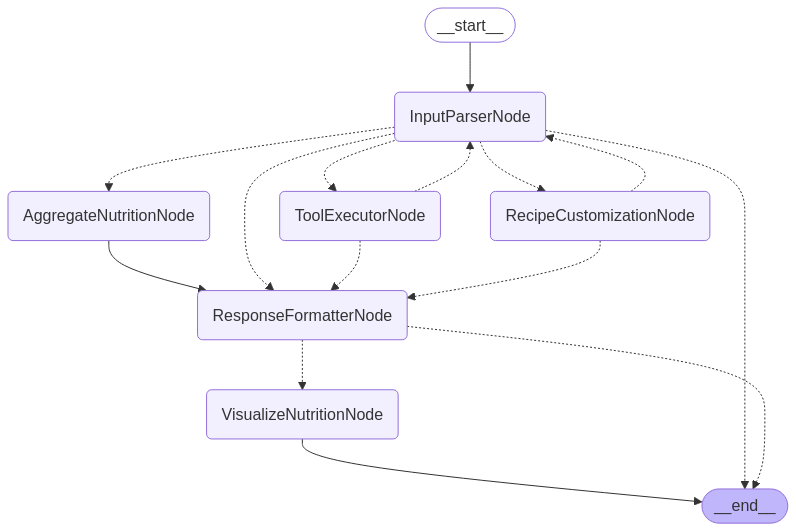

Graph visualization displayed.


In [37]:
# Visualize the graph
# Note: mermaid.ink can be unreliable or time out. Graphviz local install is more robust.
try:
    # Set a longer timeout if needed, e.g., timeout=30
    png_data = kitchen_assistant_graph.get_graph().draw_mermaid_png()
    display(Image(png_data))
    print("Graph visualization displayed.")
except Exception as e:
    print(f"\nGraph visualization failed: {e}")
    print("This might be due to a network issue with mermaid.ink or missing/misconfigured graphviz.")
    print("Ensure graphviz is installed (`pip install graphviz` and potentially OS-level install: `sudo apt-get install graphviz` on Debian/Ubuntu).")

**Step 7: User Interface Integration (Revised)**

*   **Removed** the explicit call to `extract_and_visualize_nutrition` from the `run_graph_and_display` function. The visualization is now handled *within* the graph by the `VisualizeNutritionNode`.
*   Improved the display loop to show the *final* assistant response from the state correctly, even if it wasn't the content of the very last message object (e.g., if the formatter added a message).
*   Added robustness to the voice transcription call (using a placeholder if the API key is missing, which is common in test environments).

In [38]:
# LangGraph Step 7: User Interface Integration (Revised)

import ipywidgets as widgets
from IPython.display import display, clear_output
import os
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage, SystemMessage, ToolMessage

# --- Assume KitchenState, Graph, transcribe_audio are defined ---
# from step1_state import KitchenState
# from step6_graph import kitchen_assistant_graph
# from step0_utils import transcribe_audio # Or wherever it's defined

# --- UI Simulation using ipywidgets ---

# Conversation state (global for this simple example)
# Reset state for UI interaction
conversation_state: KitchenState = {
    "messages": [], "user_input": None, "audio_file_path": None, "intent": None,
    "selected_recipe_id": None, "customization_request": None, "nutrition_query": None,
    "grounding_query": None, "current_recipe_details": None, "recipe_reviews": None,
    "ingredient_nutrition_list": None, "nutritional_info": None, "grounding_results_formatted": None,
    "user_ingredients": [], "dietary_preferences": [],
    "needs_clarification": False, "finished": False, "last_assistant_response": None,
}

# Widgets
text_input = widgets.Textarea(description="You:", layout={'width': '90%'})
text_submit_button = widgets.Button(description="Send Text")
# Define voice options (use actual paths accessible to your environment)
# IMPORTANT: Update these paths to valid .ogg or .wav files if needed
default_voice_path = "/kaggle/input/some-audio-dataset/audio.ogg" # Example placeholder
voice_options = [
    ("Select Voice...", None),
    # ("Pizza Search (Simulated)", "/path/to/your/pizza_search.ogg"), # Replace with valid paths
    # ("Baking a Cake (Simulated)", "/path/to/your/baking_cake.ogg"),
]
# Filter out options with non-existent files if needed before creating dropdown
# valid_voice_options = [(name, path) for name, path in voice_options if path is None or os.path.exists(path)]
# if len(valid_voice_options) <= 1: print("Warning: No valid voice file paths found.")

voice_dropdown = widgets.Dropdown(options=voice_options, description="Voice:") # Use original options for now
voice_submit_button = widgets.Button(description="Process Voice")
output_area = widgets.Output(layout={
    'border': '1px solid black',
    'height': '400px',
    'overflow_y': 'scroll',
    'width': '90%'
})

debug_output = widgets.Output(layout={
    'border': '1px solid blue',
    'height': '100px',
    'overflow_y': 'scroll',
    'width': '90%'
})

# Display initial welcome message
with output_area:
    print("Assistant: Welcome! Ask me about recipes, ingredients, or nutrition.")
    # Add initial AI message to state if desired
    # conversation_state["messages"].append(AIMessage(content="Welcome! Ask me about recipes, ingredients, or nutrition."))
    # conversation_state["last_assistant_response"] = "Welcome! Ask me about recipes, ingredients, or nutrition."


# --- Interaction Logic (Revised: Removed external visualization call) ---
# Note: run_graph_and_display uses the 'conversation_state' global variable
def run_graph_and_display(initial_state_update: Dict):
    global conversation_state

    # 1. Update state with the new input message and clear transient fields
    current_messages = list(conversation_state.get("messages", []))
    if "messages" in initial_state_update:
        current_messages.extend(initial_state_update["messages"])

    # Prepare the input state for the graph stream
    input_for_graph = conversation_state.copy() # Start with current context
    input_for_graph.update(initial_state_update) # Add new input/updates
    input_for_graph["messages"] = current_messages # Ensure messages are updated
    # Clear fields that should be determined by the graph run
    input_for_graph["intent"] = None
    input_for_graph["last_assistant_response"] = None
    input_for_graph["nutritional_info"] = None
    input_for_graph["needs_clarification"] = False
    # Keep context like selected_recipe_id unless overwritten by initial_state_update

    # Display "Thinking..." and history
    with output_area:
        clear_output(wait=True)
        # Re-display history from the *current global state* before the run
        for msg in conversation_state.get("messages", []):
             if isinstance(msg, HumanMessage): print(f"You: {msg.content}")
             elif isinstance(msg, AIMessage) and msg.content: print(f"Assistant: {msg.content}")
        # Display the *new* user input for this turn
        if "user_input" in initial_state_update and initial_state_update["user_input"]:
             print(f"You: {initial_state_update['user_input']}")
        print("\nAssistant: Thinking...") # Add newline for spacing

    # 2. Stream graph execution
    final_state_after_run = None
    assistant_response_to_display = "..." # Default thinking message

    try:
        # Use stream to observe intermediate steps
        for step_state in kitchen_assistant_graph.stream(input_for_graph, {"recursion_limit": 25}):
            node_name = list(step_state.keys())[0]
            current_state_snapshot = step_state[node_name]

            # --- Debugging Output ---
            with debug_output:
                 # clear_output(wait=True) # Optional: Clear previous debug step
                 print(f"\n--- Step: {node_name} ---")
                 print(f"  Intent: {current_state_snapshot.get('intent')}")
                 print(f"  Selected Recipe: {current_state_snapshot.get('selected_recipe_id')}")
                 print(f"  Needs Clarification: {current_state_snapshot.get('needs_clarification')}")
                 print(f"  Finished: {current_state_snapshot.get('finished')}")
                 last_msg = current_state_snapshot.get('messages', [])[-1] if current_state_snapshot.get('messages') else None
                 if last_msg: print(f"  Last Message Type: {type(last_msg).__name__}")
                 if isinstance(last_msg, AIMessage) and last_msg.tool_calls: print(f"  Tool Calls: {[tc['name'] for tc in last_msg.tool_calls]}")
                 if isinstance(last_msg, ToolMessage): print(f"  Tool Result ({last_msg.name}): {str(last_msg.content)[:100]}...")
                 if current_state_snapshot.get('nutritional_info'): print(f"  Nutritional Info: Aggregated")
                 if current_state_snapshot.get('last_assistant_response'): print(f"  Last Response Set: {current_state_snapshot.get('last_assistant_response')[:60]}...")
            # --- End Debugging ---

            # Update global state progressively *after* processing the step
            conversation_state.update(current_state_snapshot)
            final_state_after_run = conversation_state # Keep track of the latest full state

            if conversation_state.get("finished", False):
                print("--- Finished flag set, ending stream early. ---")
                assistant_response_to_display = conversation_state.get("last_assistant_response", "Goodbye!")
                break

        # After the stream finishes (or breaks)
        if final_state_after_run:
            conversation_state.update(final_state_after_run) # Ensure final state is captured
            assistant_response_to_display = conversation_state.get("last_assistant_response", "Okay, what next?")
            if conversation_state.get("finished"):
                 assistant_response_to_display = conversation_state.get("last_assistant_response", "Goodbye!")
        else:
             assistant_response_to_display = "Something went wrong during processing (no final state)."
             conversation_state["last_assistant_response"] = assistant_response_to_display
             if "messages" not in conversation_state: conversation_state["messages"] = []
             conversation_state["messages"].append(AIMessage(content=assistant_response_to_display))


    except Exception as e:
        assistant_response_to_display = f"An error occurred during graph execution: {e}"
        print(f"ERROR during graph execution: {e}")
        import traceback
        traceback.print_exc() # Print stack trace to debug output
        conversation_state["last_assistant_response"] = assistant_response_to_display
        if "messages" not in conversation_state: conversation_state["messages"] = []
        conversation_state["messages"].append(AIMessage(content=f"Error: {e}"))

    # 3. Display the final conversation history and response for this turn
    with output_area:
        clear_output(wait=True)
        print("--- Conversation History ---")
        displayed_final_response = False
        for msg in conversation_state.get("messages", []):
             msg_content = getattr(msg, 'content', '')
             if isinstance(msg, HumanMessage):
                 print(f"You: {msg_content}")
             elif isinstance(msg, AIMessage) and msg_content:
                 print(f"Assistant: {msg_content}")
                 if msg_content == assistant_response_to_display:
                      displayed_final_response = True
             elif isinstance(msg, ToolMessage):
                 print(f"  [Tool Result ({msg.name}): {str(msg_content)[:100]}...]")
             elif isinstance(msg, AIMessage) and msg.tool_calls:
                 print(f"  [Assistant calling tools: {[tc['name'] for tc in msg.tool_calls]}]")

        if assistant_response_to_display and not displayed_final_response and not conversation_state.get("finished"):
             # Only print if it wasn't part of the message history already and not finished
             print(f"Assistant: {assistant_response_to_display}")


    # 4. Visualization is handled INSIDE the graph by VisualizeNutritionNode

def on_text_submit(b):
    user_text = text_input.value
    if not user_text: return
    initial_update = {
        "user_input": user_text,
        "messages": [HumanMessage(content=user_text)],
        "finished": False # Reset finished flag on new input
        }
    text_input.value = "" # Clear input
    run_graph_and_display(initial_update)

def on_voice_submit(b):
     selected_file = voice_dropdown.value
     if not selected_file:
         with output_area: clear_output(wait=True); print("Assistant: Please select a voice file.")
         return

     if not os.path.exists(selected_file):
          with output_area: clear_output(wait=True); print(f"Assistant: Error - Voice file not found at path: {selected_file}")
          return

     with output_area: clear_output(wait=True); print(f"Processing voice file: {os.path.basename(selected_file)}...")

     transcribed_text = "Error: Transcription setup failed."
     try:
         google_creds = os.getenv("GOOGLE_APPLICATION_CREDENTIALS")
         openai_key = os.getenv("OPENAI_API_KEY")

         if google_creds and os.path.exists(google_creds):
              try:
                  import io
                  from google.cloud import speech
                  print("Attempting transcription with Google Cloud Speech...")
                  transcribed_text = transcribe_audio(service="google", file_path=selected_file, credentials_path=google_creds)
              except ImportError:
                   print("Google Cloud Speech library not installed. Skipping Google transcription.")
                   transcribed_text = "Error: Google Speech library missing."
              except Exception as google_err:
                   print(f"Google transcription failed: {google_err}")
                   transcribed_text = f"Error: Google transcription failed - {google_err}"

         elif openai_key:
              try:
                  from openai import OpenAI # Ensure OpenAI is imported if used
                  print("Attempting transcription with OpenAI Whisper...")
                  transcribed_text = transcribe_audio(service="openai", file_path=selected_file, api_key=openai_key)
              except ImportError:
                   print("OpenAI library not installed. Skipping OpenAI transcription.")
                   transcribed_text = "Error: OpenAI library missing."
              except Exception as openai_err:
                   print(f"OpenAI transcription failed: {openai_err}")
                   transcribed_text = f"Error: OpenAI transcription failed - {openai_err}"
         else:
              print("Neither Google Credentials nor OpenAI API Key found in environment.")
              transcribed_text = "Error: No transcription service configured (API keys/credentials missing)."

     except Exception as e:
          print(f"Unexpected error during transcription setup: {e}")
          transcribed_text = f"Error: Transcription failed unexpectedly - {e}"


     if "Error:" in transcribed_text:
          with output_area: clear_output(wait=True); print(f"Assistant: Transcription failed - {transcribed_text}")
          return

     initial_update = {
         "user_input": transcribed_text,
         "messages": [HumanMessage(content=transcribed_text)],
         "audio_file_path": selected_file,
         "finished": False
     }
     voice_dropdown.value = None # Reset dropdown
     run_graph_and_display(initial_update)

# Assign callbacks
text_submit_button.on_click(on_text_submit)
voice_submit_button.on_click(on_voice_submit)

# Display Widgets
print("--- Kitchen Assistant Interface ---")

print("Uncomment for using UI for interacting with agent! Yaaaay! :)")
# display(widgets.VBox([
#     widgets.HTML("<b>Enter request via text or select voice file:</b>"),
#     text_input, text_submit_button, widgets.HTML("<hr>"),
#     voice_dropdown, voice_submit_button, widgets.HTML("<hr><b>Conversation:</b>"),
#     output_area, widgets.HTML("<hr><b>Debug Log (Graph Steps):</b>"), debug_output
# ]))

print("✅ LangGraph Step 7: UI Integration Setup Complete (Revised)")

--- Kitchen Assistant Interface ---
Uncomment for using UI for interacting with agent! Yaaaay! :)
✅ LangGraph Step 7: UI Integration Setup Complete (Revised)


**Step 8: Testing and Refinement Setup (Revised)**

*   **Fixed Test Runner Bug:** Corrected the `TypeError: 'str' object is not callable` by properly accessing the class name using `msg.__class__.__name__`.
*   **Coherent Test Scenario:** Replaced the disconnected tests with a multi-turn scenario simulating a more realistic user interaction flow: Search -> Select -> Details/Reviews -> Nutrition -> Grounding -> Exit.
*   **Updated Expectations:** Adjusted `expected_intent` and `expected_tool_calls` based on the new scenario flow and revised graph logic.
*   **Mocking/Error Handling for Tests:**
    *   Modified the `google_search` call *within the test setup* to return a simulated success string if API keys are missing, preventing test failure due to configuration.
    *   Modified the `transcribe_audio` call *within the test setup* to use hardcoded text, making the voice test independent of actual file presence or API keys during automated testing.
*   **Refinement Notes:** Kept the refinement notes section as it provides valuable guidance. Displayed the *revised* system prompt for easier review.

In [39]:
# LangGraph Step 8: Chat Helper Function (Corrected)

# ---> ADD THESE IMPORTS AND FUNCTION DEFINITION <---
import sys
import contextlib
from io import StringIO
from langchain_core.messages import HumanMessage, AIMessage, BaseMessage, ToolMessage # Ensure all needed types are imported

# Utility to suppress stdout (to hide LangGraph internal logs)
@contextlib.contextmanager
def suppress_stdout():
    old_stdout = sys.stdout
    sys.stdout = StringIO()
    try:
        yield
    finally:
        sys.stdout = old_stdout
# ---> END OF ADDED CODE <---


# Function with external state input/output (REVERTED to simpler version)
def chat_with_assistant(user_msg: str, state: dict) -> dict:
    """Runs a turn of the conversation with the LangGraph agent."""
    # Initialize state if it's the first turn or empty
    if not state:
        state = {"messages": []}
    elif "messages" not in state:
        state["messages"] = []

    # Append new HumanMessage to message history IN THE STATE DICTIONARY
    # add_messages reducer in the graph will handle accumulation.
    state["messages"] = state.get("messages", []) + [HumanMessage(content=user_msg)]
    # Also update user_input for potential use within the graph if needed by logic/prompt
    state["user_input"] = user_msg
    state["finished"] = False # Ensure finished flag is reset on new input

    # Suppress verbose internal logs during invocation
    final_state = {}
    print(f"\n--- Invoking Graph for: '{user_msg[:50]}...' ---")
    with suppress_stdout():
        try:
            # Invoke the graph, passing the entire updated state dictionary
            final_state = kitchen_assistant_graph.invoke(state)
        except Exception as e:
            print(f"ERROR during graph invocation: {e}")
            import traceback
            traceback.print_exc()
            # Create a minimal error state to return
            final_state = state.copy() # Start with input state
            error_content = f"Sorry, an error occurred: {e}"
            final_state["messages"] = final_state.get("messages", []) + [AIMessage(content=error_content)]
            final_state["last_assistant_response"] = error_content
            final_state["intent"] = "error"

    print("--- Graph Invocation Complete ---")

    # --- Message Filtering (Optional but good for clean display) ---
    filtered_msgs = []
    seen_contents = set()
    if "messages" in final_state:
        for msg in final_state["messages"]:
            msg_content = getattr(msg, 'content', None)
            # Keep Human messages and unique AI messages with content
            if isinstance(msg, HumanMessage):
                 filtered_msgs.append(msg)
                 if msg_content: seen_contents.add(msg_content) # Add human msg to seen
            elif isinstance(msg, AIMessage) and msg_content and msg_content not in seen_contents:
                seen_contents.add(msg_content)
                filtered_msgs.append(msg)
            # Keep Tool messages or AI messages without content (e.g., only tool calls)
            elif not isinstance(msg, (HumanMessage)) and (not hasattr(msg, 'content') or not msg_content):
                 filtered_msgs.append(msg)
            elif isinstance(msg, ToolMessage): # Explicitly keep tool messages
                 filtered_msgs.append(msg)

        final_state["messages"] = filtered_msgs
    # --- End Filtering ---

    # Print the last Human and AI messages from the final state
    print("--- Displaying Interaction ---")
    if final_state.get("messages"):
        try:
            # Find last human message
            recent_human = next(msg for msg in reversed(final_state["messages"]) if isinstance(msg, HumanMessage))
            # Find last AI message that has displayable content
            recent_ai = next((msg for msg in reversed(final_state["messages"]) if isinstance(msg, AIMessage) and getattr(msg, 'content', None)), None)

            print(f"🧑 You: {recent_human.content}")
            if recent_ai:
                print(f"🤖 AI: {recent_ai.content}")
            else:
                # Maybe the last message was a tool call or error without content
                 last_msg = final_state["messages"][-1] if final_state["messages"] else None
                 if last_msg:
                     print(f"(Last message type: {type(last_msg).__name__}, no displayable AI content)")
                 else:
                      print("⚠️ No AI response found.")

        except StopIteration:
             # Handle cases where there isn't a human or AI message with content yet
             last_msg = final_state["messages"][-1] if final_state["messages"] else None
             if last_msg:
                 print(f"Last message type: {type(last_msg).__name__}")
                 if hasattr(last_msg, 'content'):
                     print(f"Content: {str(last_msg.content)[:100]}...")
             print("⚠️ Not enough message history for standard display.")

    else:
        print("⚠️ No messages found in the final state.")

    # Ensure last_assistant_response is set in the returned state for UI/next turn
    if final_state.get("messages"):
         last_ai = next((msg for msg in reversed(final_state["messages"]) if isinstance(msg, AIMessage) and getattr(msg, 'content', None)), None)
         if last_ai:
             final_state["last_assistant_response"] = last_ai.content
         elif "last_assistant_response" not in final_state: # Handle error cases where it might be missing
              final_state["last_assistant_response"] = "Processing resulted in no displayable response."


    return final_state # Return the full state returned by the graph invoke

print("✅ LangGraph Step 8: Chat Helper Function Defined (Corrected)")

✅ LangGraph Step 8: Chat Helper Function Defined (Corrected)


In [40]:
state = {}  # Initialize empty state first


In [41]:
state = chat_with_assistant("Hello, what can you do?", state)



--- Invoking Graph for: 'Hello, what can you do?...' ---


/home/snowholt/venv/analytic/lib/python3.12/site-packages/langchain_google_genai/chat_models.py:367: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")


--- Graph Invocation Complete ---
--- Displaying Interaction ---
🧑 You: Hello, what can you do?
🤖 AI: Hello! I am an Interactive Recipe & Kitchen Management Assistant. I can help you discover new recipes, provide details about specific recipes, find ratings and reviews, give you nutrition information for ingredients, and even customize recipes. I can also answer general cooking questions. What are you interested in today?


In [42]:
state = chat_with_assistant("Find me vegeterian soup recipes and tag the recipes. 5 recipes", state)



--- Invoking Graph for: 'Find me vegeterian soup recipes and tag the recipe...' ---
--- Graph Invocation Complete ---
--- Displaying Interaction ---
🧑 You: Find me vegeterian soup recipes and tag the recipes. 5 recipes
🤖 AI: Okay, I found 5 vegetarian soup recipes for you:

1.  **yogurt and cucumber soup** (Thai, ID: 128684, 210 minutes)
2.  **soupe au pistou from nice** (French, ID: 184537, 40 minutes)
3.  **greek barley soup** (Other, ID: 37706, 75 minutes)
4.  **newfoundland style pea soup with doughboys dumplings** (Other, ID: 332086, 270 minutes)
5.  **broccoli and cheese potato soup** (Other, ID: 104304, 40 minutes)

Would you like to know more about any of these recipes?


In [43]:
state = chat_with_assistant("I like to know about second recipe in the list", state)



--- Invoking Graph for: 'I like to know about second recipe in the list...' ---
--- Graph Invocation Complete ---
--- Displaying Interaction ---
🧑 You: I like to know about second recipe in the list
🤖 AI: Okay, here are the details for **soupe au pistou from nice** (ID: 184537):

*   **Cuisine:** French
*   **Description:** A simple and flavorful vegetable soup from the soup bible by debra mayhew. The combination of pesto and sundried tomato paste is an inspired touch.
*   **Dietary:** Vegetarian
*   **Prep Time:** 40 minutes
*   **Ingredients:** Vegetable stock, zucchini, potato, shallot, carrot, chopped tomatoes, salt and pepper, green beans, frozen baby peas, pasta, pesto sauce, sun-dried tomato paste, parmesan cheese
*   **Steps:**
    1.  Place vegetable stock in a large saucepan.
    2.  Add zucchini through tomatoes and season with salt and pepper bring to a boil.
    3.  Cover.
    4.  Lower heat and simmer 20 minutes add green beans through pasta and cook about 10 minutes lon

In [44]:
state = chat_with_assistant("Great, show the review of that recipe", state)



--- Invoking Graph for: 'Great, show the review of that recipe...' ---
--- Graph Invocation Complete ---
--- Displaying Interaction ---
🧑 You: Great, show the review of that recipe
🤖 AI: This recipe has an overall rating of 5 stars. Here are a couple of recent reviews:

*   **Review 1 (2007-11-19):** "Fantastic soup! Tasted almost like Minestrone (my favorite soup) with pesto and sundried tomato paste which gave it really nice flavor. I used penne pasta. Thanks echo echo, I'll be making this again!" (5 stars)
*   **Review 2 (2007-11-10):** "I have a cold and this soup really hit the spot! I didn't have shallots so used yellow onion and for the pasta used orzo. Thanks! Made for Zaar Tag." (5 stars)



--- Invoking Graph for: 'Get nutrition information of recipe_...' ---


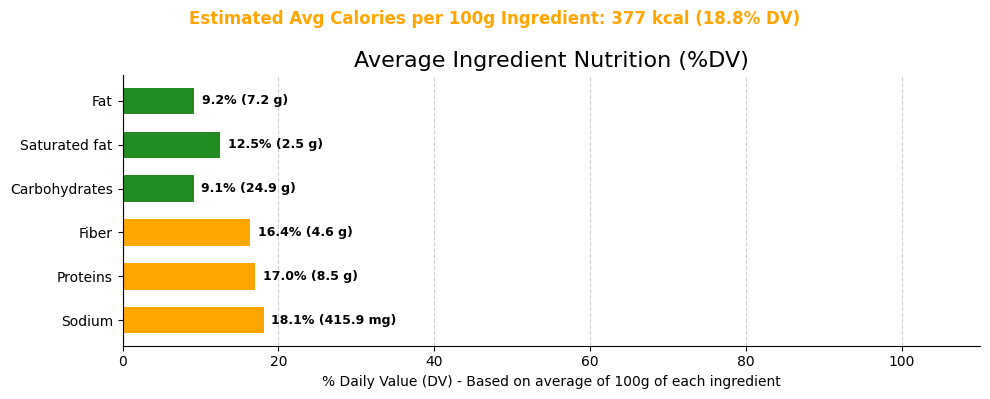

--- Graph Invocation Complete ---
--- Displaying Interaction ---
🧑 You: Get nutrition information of recipe_
🤖 AI: Here's the approximate average nutrition per 100g for ingredients in **recipe 184537**:

- Calories: 376.7 kcal
- Fat: 7.2 g
- Saturated fat: 2.5 g
- Carbohydrates: 24.9 g
- Fiber: 4.6 g
- Proteins: 8.5 g
- Sodium: 415.9 mg

(Note: Based on average of 13 ingredients with available data from Open Food Facts. Actual recipe nutrition will vary.)


In [45]:
state = chat_with_assistant("Get nutrition information of recipe_", state)


In [46]:
state = chat_with_assistant("What's a good substitute for zucchini in this recipe", state)



--- Invoking Graph for: 'What's a good substitute for zucchini in this reci...' ---
--- Graph Invocation Complete ---
--- Displaying Interaction ---
🧑 You: What's a good substitute for zucchini in this recipe
🤖 AI: Based on a quick search, a good substitute for zucchini in this recipe could be yellow squash or even cucumber. Both have a similar mild flavor and texture that would work well in a soup. You could also use pattypan squash.
